### DLthon 진행 과정
- 1일차: 베이스라인 선정 및 Featuere Engineering 에 집중
- 2일차: 정칙화와 LaneNet를 통한 lane Mark 개선에 집중
- 3일차: 상호지식 증류를 통한 Lane Mark 개선 시도

### 2일차 Task
 #### 목표
 - Lane mark의 IoU 성능 개선
 - Lane에 최적화된 모델 LaneNet를 보조헤드로 추가
 - 정칙화를 중심으로 베이스라인 개선에 집중
   
 #### Process
- Main Model → DeepLab V3
- Lane Embedding Head (Aux branch) Model → LaneNet

- W&B, Grad-CAM 미적용

### Process
- 1 LaneNet 적용가능성(EDA)
- 2. DataLoader 생성
- 3. 모델 학습 및 테스트
- 4. DeepLabV3+ 기반 Multi-Head Lane Awareness 강화 모델
4 DeepLabV3 + Lane Embedding Regularization 및 하이퍼파라미터 조정
#### (Multi-Head Segmentation Model) - LANE 보조헤드 추가(laneNet)

### 회고
- 전날 Feature Engineering 에서 오히려 성능이 떨어진 것을 개선하기 위한 방안
- 정칙화를 통하여 약간의 성능 개선
- LanNet를 이용한 Lane Mark 학습에 집중하였으나 성과는 개선되지 않았음
- 앞으로 추가 개선 방법 고민 필요

  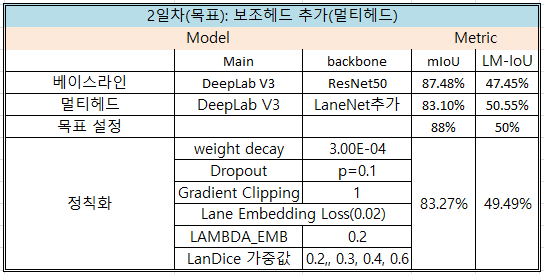

### 1 LaneNet 적용 가능성 판단

,Lane Annotation Count per Image,Number of Images,Ratio (%)
0,0,3,1.5
1,1,193,96.5
2,2,3,1.5
3,3,0,0.0
4,4,0,0.0
5,5,0,0.0
6,6,0,0.0
7,7,0,0.0
8,8,1,0.5


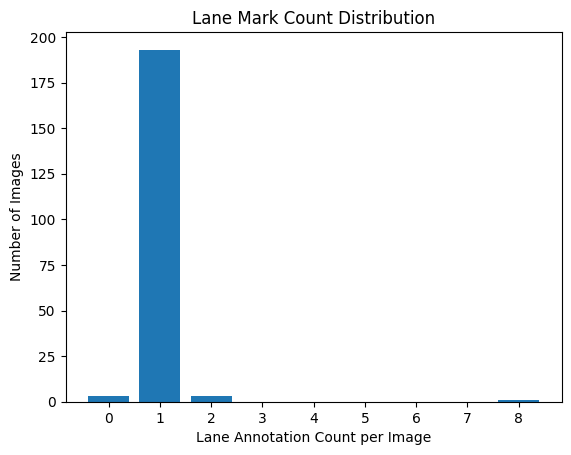

In [5]:
import os, json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt


# ===== 로컬 경로 =====
import os

DATA_ROOT = r"D:\PyProject\AIFFEL_AI\CNN\data\motorcycle_dataset\www.acmeai.tech ODataset 1 - Motorcycle Night Ride Dataset"

IMG_DIR  = os.path.join(DATA_ROOT, "images")
ann_path = os.path.join(DATA_ROOT, "COCO_motorcycle (pixel).json")

with open(ann_path, "r", encoding="utf-8") as f:
    coco = json.load(f)

# lane category 찾기
id2name = {c["id"]: c.get("name", "") for c in coco["categories"]}
lane_cat_ids = [cid for cid, name in id2name.items() if "lane" in (name or "").lower()]

# 이미지별 lane annotation 개수 집계
img2lane_cnt = Counter()
for a in coco["annotations"]:
    if a["category_id"] in lane_cat_ids:
        img2lane_cnt[a["image_id"]] += 1

num_images = len(coco["images"])

# 분포 계산 (lane 없는 이미지 포함)
dist = Counter(img2lane_cnt.values())
lane_cnt_full = Counter({i: 0 for i in range(max(dist.keys()) + 1)})
lane_cnt_full.update(dist)
lane_cnt_full[0] = num_images - sum(dist.values())

# ---- 표 생성 ----
xs = sorted(lane_cnt_full.keys())
ys = [lane_cnt_full[x] for x in xs]



df = pd.DataFrame({
    "Lane Annotation Count per Image": xs,
    "Number of Images": ys,
    "Ratio (%)": [round(y / num_images * 100, 2) for y in ys]
})


display(df)

# ---- 막대 그래프 ----
plt.figure()
plt.bar(xs, ys)
plt.xlabel("Lane Annotation Count per Image")
plt.ylabel("Number of Images")
plt.title("Lane Mark Count Distribution")
plt.xticks(xs)

plt.show()


### 2. 데이터 준비(DataLoader 생성)

In [4]:
# COCO 라벨(JSON + 폴리곤)을 → 딥러닝이 학습할 수 있는 이미지와 마스크로 바꿔주는 Dataset 클래스
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils

class COCOSemSeg(Dataset):
    def __init__(self, ann_path, img_dir, img_ids, id2train, size=(512,512),
                 train=True, transform_img=None, priority_order=None):
        self.coco = COCO(ann_path)
        self.img_dir = img_dir
        self.img_ids = list(img_ids)
        self.id2train = id2train
        self.size = size
        self.train = train
        self.transform_img = transform_img
        self.priority_order = priority_order  # 예: ["Undrivable","Moveable","My bike","Rider","Road","Lane Mark"]

        # cat id -> name
        self.catid2name = {c["id"]: c["name"] for c in self.coco.cats.values()}
        # name -> cat id
        self.name2catid = {v:k for k,v in self.catid2name.items()}

    def _ann_to_mask(self, anns, H, W):
        mask = np.zeros((H, W), dtype=np.int64)

        # 덮어쓰기 순서 결정
        if self.priority_order:
            # name 기준으로 ann 정렬 (뒤에 오는 게 최종 덮어쓰기 되도록)
            pr = {name:i for i, name in enumerate(self.priority_order)}
            anns = sorted(anns, key=lambda a: pr.get(self.catid2name[a["category_id"]], -1))
        # priority_order 없으면 그냥 anns 순서대로 덮어씀

        for a in anns:
            cat_id = a["category_id"]
            train_id = self.id2train.get(cat_id, 0)  # 없으면 background
            rles = self.coco.annToRLE(a)  # polygon -> RLE
            m = maskUtils.decode(rles).astype(bool)  # (H,W) bool
            mask[m] = train_id

        return mask

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])
        img = Image.open(img_path).convert("RGB")

        H, W = info["height"], info["width"]
        ann_ids = self.coco.getAnnIds(imgIds=[img_id])
        anns = self.coco.loadAnns(ann_ids)

        mask = self._ann_to_mask(anns, H, W)

        # resize (PIL: img=bilinear, mask=nearest)
        img = img.resize(self.size, Image.BILINEAR)
        
        mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)
        mask = np.array(mask_pil, dtype=np.int64)
        
        if self.transform_img is not None:
            img = self.transform_img(img)
        
        mask = torch.from_numpy(mask)  # (H,W) long
        return img, mask

In [6]:
# 학습할 클래스 번호와 데이터 분할

from pycocotools.coco import COCO
import numpy as np

coco = COCO(ann_path)
cat_ids = sorted(coco.getCatIds())         # 6개 cat_id
id2train = {cid:i+1 for i,cid in enumerate(cat_ids)}  # 0=background, 1..6=classes

img_ids = sorted(coco.imgs.keys())
np.random.seed(42)
np.random.shuffle(img_ids)

n = len(img_ids)
train_ids = img_ids[: int(0.8*n)]
val_ids   = img_ids[int(0.8*n): int(0.9*n)]
test_ids  = img_ids[int(0.9*n):]

loading annotations into memory...
Done (t=1.21s)
creating index...
index created!


In [6]:
# =========================
# 2) Dataset / DataLoader 구성 (추천)
# =========================
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = (DEVICE == "cuda")

SIZE = (512, 512)
BATCH_SIZE = 4
NUM_WORKERS = 0  # Windows: 0부터 시작 → 문제 없으면 2

transform_img = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])

# LaneNet 목적(도로 위 lane 보존 + 객체는 lane을 가리게)
priority_order = ["Undrivable", "Road", "Lane Mark", "Moveable", "My bike", "Rider"]

train_dataset = COCOSemSeg(ann_path, IMG_DIR, train_ids, id2train, size=SIZE,
                           train=True, transform_img=transform_img, priority_order=priority_order)
val_dataset   = COCOSemSeg(ann_path, IMG_DIR, val_ids,   id2train, size=SIZE,
                           train=False, transform_img=transform_img, priority_order=priority_order)
test_dataset  = COCOSemSeg(ann_path, IMG_DIR, test_ids,  id2train, size=SIZE,
                           train=False, transform_img=transform_img, priority_order=priority_order)

NUM_CLASSES = max(id2train.values()) + 1  # background 포함

loader_kwargs = dict(
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
)

if NUM_WORKERS > 0:
    loader_kwargs.update(dict(persistent_workers=True, prefetch_factor=2))

train_loader = DataLoader(train_dataset, shuffle=True, drop_last=True, **loader_kwargs)
val_loader   = DataLoader(val_dataset,   shuffle=False, drop_last=False, **loader_kwargs)
test_loader  = DataLoader(test_dataset,  shuffle=False, drop_last=False, **loader_kwargs)

# ---- sanity check (최소) ----
x, y = next(iter(train_loader))
print("DEVICE:", DEVICE, "| NUM_CLASSES:", NUM_CLASSES)
print("x:", x.shape, x.dtype)
print("y:", y.shape, y.dtype, "min/max:", int(y.min()), int(y.max()))
print("batch class counts:", torch.bincount(y.flatten(), minlength=NUM_CLASSES).tolist())

loading annotations into memory...
Done (t=1.30s)
creating index...
index created!
loading annotations into memory...
Done (t=1.19s)
creating index...
index created!
loading annotations into memory...
Done (t=1.17s)
creating index...
index created!


C:\Users\hugctx\AppData\Local\Temp\ipykernel_41028\2798210657.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)


DEVICE: cuda | NUM_CLASSES: 7
x: torch.Size([4, 3, 512, 512]) torch.float32
y: torch.Size([4, 512, 512]) torch.int64 min/max: 0 6
batch class counts: [5717, 439378, 353864, 8210, 8392, 151024, 81991]


### 3 모델 학습 및 테스트

In [11]:
# Lane train id 확인 + class weight 계산 /Lane id 확인은 한 번만. class weight도 한 번만 계산해서 이후에 재사용.

id2name = {c["id"]: c["name"] for c in coco.cats.values()}
cat_ids = sorted(coco.getCatIds())
train2name = {i+1: id2name[cid] for i, cid in enumerate(cat_ids)}  # 0은 background
print(train2name)

# (선택) class weight 계산 (train 전체 기준)
import torch

def compute_class_weights(loader, num_classes, max_batches=None):
    counts = torch.zeros(num_classes, dtype=torch.long)
    for bi, (_, y) in enumerate(loader):
        if max_batches is not None and bi >= max_batches:
            break
        counts += torch.bincount(y.flatten(), minlength=num_classes).cpu()
    freq = counts.float().clamp(min=1.0)
    w = (1.0 / torch.sqrt(freq))
    w = w / w.mean()
    return w, counts

class_weights, class_counts = compute_class_weights(train_loader, NUM_CLASSES, max_batches=None)
print("class_counts:", class_counts.tolist())
print("class_weights:", [round(v, 3) for v in class_weights.tolist()])


{1: 'Undrivable', 2: 'Road', 3: 'Lane Mark', 4: 'Moveable', 5: 'My bike', 6: 'Rider'}


C:\Users\hugctx\AppData\Local\Temp\ipykernel_41028\2798210657.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)


class_counts: [237975, 17865033, 11153331, 533177, 1978380, 6824917, 3350227]
class_weights: [2.564, 0.296, 0.375, 1.713, 0.889, 0.479, 0.683]


DEVICE=cuda | NUM_CLASSES=7 | IGNORE_BG_IN_mIoU=True | PATIENCE=5
Regularization change: WEIGHT_DECAY=3e-4 (was 1e-4)
Targets: mIoU>=0.85, LaneIoU>=0.55 (Lane train_id=3)
Save best to: best_deeplabv3_r50_baseline_2.pt



train:   0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\hugctx\AppData\Local\Temp\ipykernel_41028\2798210657.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)


[01] train_loss=0.6890 | val_loss=0.4530 | val_mIoU(no-bg)=0.7185 | laneIoU=0.2532
  IoU[1] Undrivable: 0.9168
  IoU[2] Road: 0.7536
  IoU[3] Lane Mark: 0.2532
  IoU[4] Moveable: 0.6587
  IoU[5] My bike: 0.8793
  IoU[6] Rider: 0.8495
  ✅ improved! best_mIoU=0.7185 @ epoch 1 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[02] train_loss=0.3528 | val_loss=0.3762 | val_mIoU(no-bg)=0.7439 | laneIoU=0.3161
  IoU[1] Undrivable: 0.9157
  IoU[2] Road: 0.7954
  IoU[3] Lane Mark: 0.3161
  IoU[4] Moveable: 0.6509
  IoU[5] My bike: 0.9271
  IoU[6] Rider: 0.8584
  ✅ improved! best_mIoU=0.7439 @ epoch 2 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[03] train_loss=0.2683 | val_loss=0.3180 | val_mIoU(no-bg)=0.7774 | laneIoU=0.3055
  IoU[1] Undrivable: 0.9282
  IoU[2] Road: 0.7991
  IoU[3] Lane Mark: 0.3055
  IoU[4] Moveable: 0.7817
  IoU[5] My bike: 0.9377
  IoU[6] Rider: 0.9124
  ✅ improved! best_mIoU=0.7774 @ epoch 3 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[04] train_loss=0.2197 | val_loss=0.3045 | val_mIoU(no-bg)=0.7940 | laneIoU=0.3859
  IoU[1] Undrivable: 0.9298
  IoU[2] Road: 0.8226
  IoU[3] Lane Mark: 0.3859
  IoU[4] Moveable: 0.7714
  IoU[5] My bike: 0.9391
  IoU[6] Rider: 0.9151
  ✅ improved! best_mIoU=0.7940 @ epoch 4 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[05] train_loss=0.1922 | val_loss=0.2812 | val_mIoU(no-bg)=0.8105 | laneIoU=0.4294
  IoU[1] Undrivable: 0.9402
  IoU[2] Road: 0.8414
  IoU[3] Lane Mark: 0.4294
  IoU[4] Moveable: 0.7905
  IoU[5] My bike: 0.9414
  IoU[6] Rider: 0.9201
  ✅ improved! best_mIoU=0.8105 @ epoch 5 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[06] train_loss=0.1744 | val_loss=0.2713 | val_mIoU(no-bg)=0.8198 | laneIoU=0.4480
  IoU[1] Undrivable: 0.9444
  IoU[2] Road: 0.8596
  IoU[3] Lane Mark: 0.4480
  IoU[4] Moveable: 0.7912
  IoU[5] My bike: 0.9458
  IoU[6] Rider: 0.9297
  ✅ improved! best_mIoU=0.8198 @ epoch 6 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[07] train_loss=0.1611 | val_loss=0.2820 | val_mIoU(no-bg)=0.8197 | laneIoU=0.4353
  IoU[1] Undrivable: 0.9469
  IoU[2] Road: 0.8575
  IoU[3] Lane Mark: 0.4353
  IoU[4] Moveable: 0.7987
  IoU[5] My bike: 0.9477
  IoU[6] Rider: 0.9320
  ❌ no improve | best_mIoU=0.8198 @ epoch 6 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[08] train_loss=0.1503 | val_loss=0.2907 | val_mIoU(no-bg)=0.8205 | laneIoU=0.4383
  IoU[1] Undrivable: 0.9461
  IoU[2] Road: 0.8598
  IoU[3] Lane Mark: 0.4383
  IoU[4] Moveable: 0.7955
  IoU[5] My bike: 0.9482
  IoU[6] Rider: 0.9350
  ✅ improved! best_mIoU=0.8205 @ epoch 8 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[09] train_loss=0.1402 | val_loss=0.2769 | val_mIoU(no-bg)=0.8261 | laneIoU=0.4644
  IoU[1] Undrivable: 0.9450
  IoU[2] Road: 0.8665
  IoU[3] Lane Mark: 0.4644
  IoU[4] Moveable: 0.7933
  IoU[5] My bike: 0.9512
  IoU[6] Rider: 0.9360
  ✅ improved! best_mIoU=0.8261 @ epoch 9 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[10] train_loss=0.1342 | val_loss=0.2946 | val_mIoU(no-bg)=0.8250 | laneIoU=0.4506
  IoU[1] Undrivable: 0.9439
  IoU[2] Road: 0.8648
  IoU[3] Lane Mark: 0.4506
  IoU[4] Moveable: 0.8041
  IoU[5] My bike: 0.9519
  IoU[6] Rider: 0.9349
  ❌ no improve | best_mIoU=0.8261 @ epoch 9 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[11] train_loss=0.1280 | val_loss=0.2914 | val_mIoU(no-bg)=0.8270 | laneIoU=0.4574
  IoU[1] Undrivable: 0.9458
  IoU[2] Road: 0.8648
  IoU[3] Lane Mark: 0.4574
  IoU[4] Moveable: 0.8052
  IoU[5] My bike: 0.9518
  IoU[6] Rider: 0.9367
  ✅ improved! best_mIoU=0.8270 @ epoch 11 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[12] train_loss=0.1230 | val_loss=0.3096 | val_mIoU(no-bg)=0.8215 | laneIoU=0.4392
  IoU[1] Undrivable: 0.9425
  IoU[2] Road: 0.8693
  IoU[3] Lane Mark: 0.4392
  IoU[4] Moveable: 0.7906
  IoU[5] My bike: 0.9518
  IoU[6] Rider: 0.9359
  ❌ no improve | best_mIoU=0.8270 @ epoch 11 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[13] train_loss=0.1184 | val_loss=0.2969 | val_mIoU(no-bg)=0.8289 | laneIoU=0.4746
  IoU[1] Undrivable: 0.9451
  IoU[2] Road: 0.8715
  IoU[3] Lane Mark: 0.4746
  IoU[4] Moveable: 0.7896
  IoU[5] My bike: 0.9541
  IoU[6] Rider: 0.9384
  ✅ improved! best_mIoU=0.8289 @ epoch 13 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[14] train_loss=0.1142 | val_loss=0.3112 | val_mIoU(no-bg)=0.8297 | laneIoU=0.4590
  IoU[1] Undrivable: 0.9459
  IoU[2] Road: 0.8714
  IoU[3] Lane Mark: 0.4590
  IoU[4] Moveable: 0.8055
  IoU[5] My bike: 0.9552
  IoU[6] Rider: 0.9408
  ✅ improved! best_mIoU=0.8297 @ epoch 14 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[15] train_loss=0.1120 | val_loss=0.3069 | val_mIoU(no-bg)=0.8259 | laneIoU=0.4629
  IoU[1] Undrivable: 0.9446
  IoU[2] Road: 0.8717
  IoU[3] Lane Mark: 0.4629
  IoU[4] Moveable: 0.7834
  IoU[5] My bike: 0.9534
  IoU[6] Rider: 0.9393
  ❌ no improve | best_mIoU=0.8297 @ epoch 14 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[16] train_loss=0.1086 | val_loss=0.3109 | val_mIoU(no-bg)=0.8292 | laneIoU=0.4637
  IoU[1] Undrivable: 0.9448
  IoU[2] Road: 0.8714
  IoU[3] Lane Mark: 0.4637
  IoU[4] Moveable: 0.7946
  IoU[5] My bike: 0.9564
  IoU[6] Rider: 0.9443
  ❌ no improve | best_mIoU=0.8297 @ epoch 14 | patience 2/5 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[17] train_loss=0.1057 | val_loss=0.3144 | val_mIoU(no-bg)=0.8295 | laneIoU=0.4606
  IoU[1] Undrivable: 0.9451
  IoU[2] Road: 0.8718
  IoU[3] Lane Mark: 0.4606
  IoU[4] Moveable: 0.7991
  IoU[5] My bike: 0.9564
  IoU[6] Rider: 0.9439
  ❌ no improve | best_mIoU=0.8297 @ epoch 14 | patience 3/5 (remain 2)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[18] train_loss=0.1035 | val_loss=0.3236 | val_mIoU(no-bg)=0.8309 | laneIoU=0.4742
  IoU[1] Undrivable: 0.9448
  IoU[2] Road: 0.8715
  IoU[3] Lane Mark: 0.4742
  IoU[4] Moveable: 0.7947
  IoU[5] My bike: 0.9566
  IoU[6] Rider: 0.9433
  ✅ improved! best_mIoU=0.8309 @ epoch 18 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[19] train_loss=0.1019 | val_loss=0.3177 | val_mIoU(no-bg)=0.8313 | laneIoU=0.4639
  IoU[1] Undrivable: 0.9464
  IoU[2] Road: 0.8757
  IoU[3] Lane Mark: 0.4639
  IoU[4] Moveable: 0.8009
  IoU[5] My bike: 0.9567
  IoU[6] Rider: 0.9443
  ✅ improved! best_mIoU=0.8313 @ epoch 19 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[20] train_loss=0.0996 | val_loss=0.3262 | val_mIoU(no-bg)=0.8301 | laneIoU=0.4700
  IoU[1] Undrivable: 0.9443
  IoU[2] Road: 0.8715
  IoU[3] Lane Mark: 0.4700
  IoU[4] Moveable: 0.7930
  IoU[5] My bike: 0.9571
  IoU[6] Rider: 0.9446
  ❌ no improve | best_mIoU=0.8313 @ epoch 19 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[21] train_loss=0.0983 | val_loss=0.3230 | val_mIoU(no-bg)=0.8329 | laneIoU=0.4745
  IoU[1] Undrivable: 0.9454
  IoU[2] Road: 0.8748
  IoU[3] Lane Mark: 0.4745
  IoU[4] Moveable: 0.8010
  IoU[5] My bike: 0.9570
  IoU[6] Rider: 0.9450
  ✅ improved! best_mIoU=0.8329 @ epoch 21 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[22] train_loss=0.0964 | val_loss=0.3292 | val_mIoU(no-bg)=0.8306 | laneIoU=0.4680
  IoU[1] Undrivable: 0.9455
  IoU[2] Road: 0.8744
  IoU[3] Lane Mark: 0.4680
  IoU[4] Moveable: 0.7938
  IoU[5] My bike: 0.9563
  IoU[6] Rider: 0.9454
  ❌ no improve | best_mIoU=0.8329 @ epoch 21 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[23] train_loss=0.0954 | val_loss=0.3343 | val_mIoU(no-bg)=0.8312 | laneIoU=0.4716
  IoU[1] Undrivable: 0.9451
  IoU[2] Road: 0.8729
  IoU[3] Lane Mark: 0.4716
  IoU[4] Moveable: 0.7956
  IoU[5] My bike: 0.9567
  IoU[6] Rider: 0.9454
  ❌ no improve | best_mIoU=0.8329 @ epoch 21 | patience 2/5 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[24] train_loss=0.0949 | val_loss=0.3306 | val_mIoU(no-bg)=0.8310 | laneIoU=0.4699
  IoU[1] Undrivable: 0.9456
  IoU[2] Road: 0.8737
  IoU[3] Lane Mark: 0.4699
  IoU[4] Moveable: 0.7950
  IoU[5] My bike: 0.9566
  IoU[6] Rider: 0.9450
  ❌ no improve | best_mIoU=0.8329 @ epoch 21 | patience 3/5 (remain 2)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[25] train_loss=0.0943 | val_loss=0.3389 | val_mIoU(no-bg)=0.8304 | laneIoU=0.4702
  IoU[1] Undrivable: 0.9442
  IoU[2] Road: 0.8744
  IoU[3] Lane Mark: 0.4702
  IoU[4] Moveable: 0.7924
  IoU[5] My bike: 0.9558
  IoU[6] Rider: 0.9457
  ❌ no improve | best_mIoU=0.8329 @ epoch 21 | patience 4/5 (remain 1)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[26] train_loss=0.0935 | val_loss=0.3416 | val_mIoU(no-bg)=0.8313 | laneIoU=0.4704
  IoU[1] Undrivable: 0.9446
  IoU[2] Road: 0.8748
  IoU[3] Lane Mark: 0.4704
  IoU[4] Moveable: 0.7957
  IoU[5] My bike: 0.9569
  IoU[6] Rider: 0.9453
  ❌ no improve | best_mIoU=0.8329 @ epoch 21 | patience 5/5 (remain 0)

Early stopping triggered.
Best val mIoU(no-bg): 0.832945 (epoch 21)

[Best Model @ VAL]
val_loss=0.3230 | val_mIoU(no-bg)=0.8329 | laneIoU=0.4745
  IoU[1] Undrivable: 0.9454
  IoU[2] Road: 0.8748
  IoU[3] Lane Mark: 0.4745
  IoU[4] Moveable: 0.8010
  IoU[5] My bike: 0.9570
  IoU[6] Rider: 0.9450


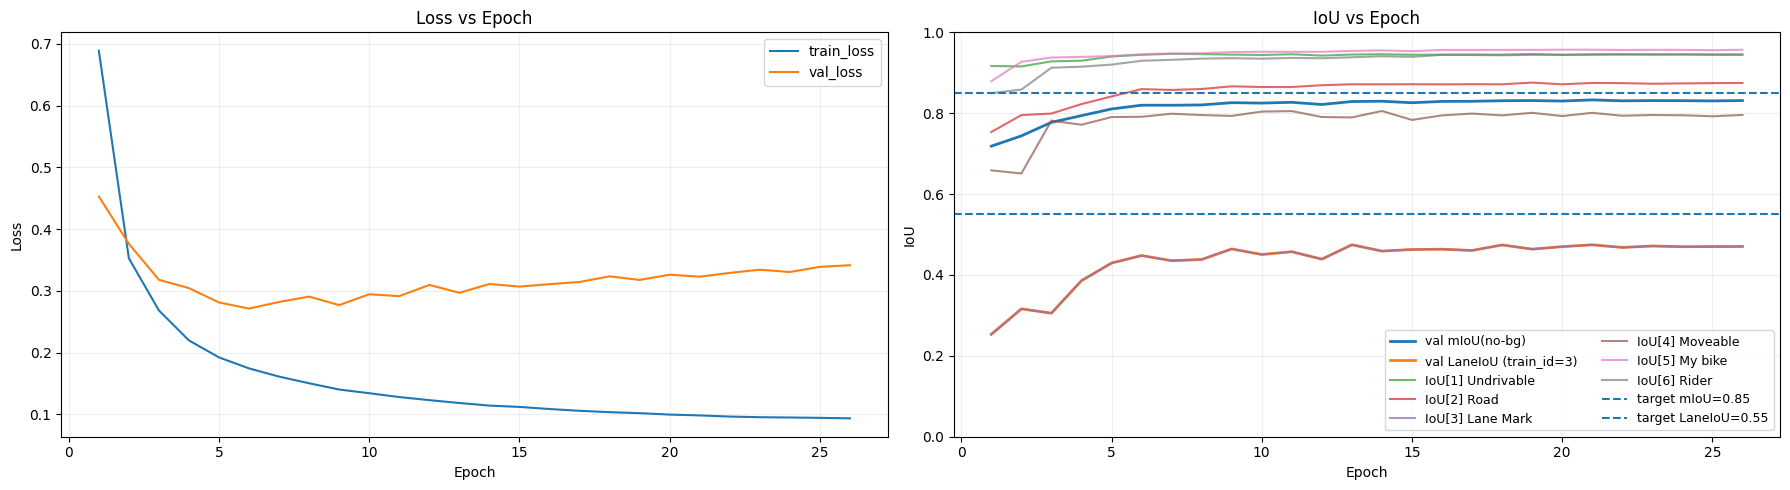

In [32]:
# =========================
# [정칙화 변경 내용]
# 1) WEIGHT_DECAY: 1e-4 -> 3e-4  (가장 안전하고 효과적인 정칙화 강화)
# 2) (선택) Backbone freeze warmup 1~2 epoch (기본 OFF)  # 필요하면 켜세요
# Baseline DeepLabV3+ResNet50 
# =========================

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# ---------- config ----------
EPOCHS = 30
PATIENCE = 5
LR = 3e-4

# ✅ 정칙화 강화: weight decay 증가
WEIGHT_DECAY = 3e-4   # (기존 1e-4 -> 3e-4)

LABEL_SMOOTH = 0.0
BEST_PATH = "best_deeplabv3_r50_baseline_2.pt"

# mIoU 계산/출력에서 background 제외
IGNORE_BG = True
PRINT_BG_IOU = False

# ✅ 목표선(원하는 값으로 수정)
TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55

# Lane Mark train_id (당신 매핑 기준: 3)
LANE_TRAIN_ID = 3

# (선택) backbone warmup freeze: 초반 과적합 줄이는 데 도움될 때 있음
FREEZE_BACKBONE_WARMUP_EPOCHS = 0  # 0이면 OFF, 1~2 추천(원하면 켜세요)

device = torch.device(DEVICE)

# ---------- class name map (train_id -> name) ----------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i+1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# ---------- model ----------
model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.to(device)

# ---------- loss ----------
use_class_weight = True
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

# ---------- optim / sched ----------
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# ---------- metrics ----------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["out"]
        loss = criterion(out, y)
        total_loss += loss.item()
        n += 1

        pred = out.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist = hist.float()
    diag = torch.diag(hist)
    denom = (hist.sum(1) + hist.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    return total_loss / max(n, 1), miou, iou

def set_backbone_trainable(model, trainable: bool):
    for p in model.backbone.parameters():
        p.requires_grad = trainable

def train_one_epoch(model, loader):
    model.train()
    total_loss = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["out"]
        loss = criterion(out, y)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # 안정화(그대로)
        optimizer.step()

        total_loss += loss.item()
        n += 1
    return total_loss / max(n, 1)

# ---------- history ----------
history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_miou": [],
    "val_iou_per_class": [],
}

# ---------- training loop ----------
best_miou = -1.0
best_epoch = 0
pat = 0

print(f"DEVICE={DEVICE} | NUM_CLASSES={NUM_CLASSES} | IGNORE_BG_IN_mIoU={IGNORE_BG} | PATIENCE={PATIENCE}")
print(f"Regularization change: WEIGHT_DECAY=3e-4 (was 1e-4)")
if FREEZE_BACKBONE_WARMUP_EPOCHS > 0:
    print(f"Backbone warmup freeze: first {FREEZE_BACKBONE_WARMUP_EPOCHS} epoch(s)")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU} (Lane train_id={LANE_TRAIN_ID})")
print(f"Save best to: {BEST_PATH}\n")

for epoch in range(1, EPOCHS + 1):
    if FREEZE_BACKBONE_WARMUP_EPOCHS > 0:
        set_backbone_trainable(model, trainable=(epoch > FREEZE_BACKBONE_WARMUP_EPOCHS))

    tr_loss = train_one_epoch(model, train_loader)
    va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
    scheduler.step()

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["val_iou_per_class"].append(va_iou_pc)

    lane_iou = float(va_iou_pc[LANE_TRAIN_ID])
    tag = "no-bg" if IGNORE_BG else "with-bg"
    print(f"[{epoch:02d}] train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | val_mIoU({tag})={va_miou:.4f} | laneIoU={lane_iou:.4f}")

    start_cid = 0 if PRINT_BG_IOU else 1
    for cid in range(start_cid, NUM_CLASSES):
        name = train2name.get(cid, str(cid))
        v = va_iou_pc[cid]
        txt = "nan" if np.isnan(v) else f"{v:.4f}"
        print(f"  IoU[{cid}] {name}: {txt}")

    improved = va_miou > best_miou + 1e-7
    if improved:
        best_miou = va_miou
        best_epoch = epoch
        pat = 0
        torch.save({"model": model.state_dict(), "id2train": id2train, "num_classes": NUM_CLASSES}, BEST_PATH)
        print(f"  ✅ improved! best_mIoU={best_miou:.4f} @ epoch {best_epoch} | patience {pat}/{PATIENCE} | saved\n")
    else:
        pat += 1
        remain = PATIENCE - pat
        print(f"  ❌ no improve | best_mIoU={best_miou:.4f} @ epoch {best_epoch} | patience {pat}/{PATIENCE} (remain {max(remain,0)})\n")
        if pat >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Best val mIoU({ 'no-bg' if IGNORE_BG else 'with-bg' }): {best_miou:.6f} (epoch {best_epoch})")

# ---------- load best + final val report ----------
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou_best = float(va_iou_pc[LANE_TRAIN_ID])

print("\n[Best Model @ VAL]")
print(f"val_loss={va_loss:.4f} | val_mIoU({ 'no-bg' if IGNORE_BG else 'with-bg' })={va_miou:.4f} | laneIoU={lane_iou_best:.4f}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = va_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# =========================
# Visualization: SIDE-BY-SIDE (좌우 배치)
# =========================

epochs = np.array(history["epoch"])
train_loss = np.array(history["train_loss"])
val_loss_arr = np.array(history["val_loss"])
val_miou_hist = np.array(history["val_miou"])
val_iou_stack = np.stack(history["val_iou_per_class"], axis=0)
lane_iou_hist = val_iou_stack[:, LANE_TRAIN_ID]

# 👉 좌우 subplot
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# =================
# (좌) Loss Plot
# =================
axes[0].plot(epochs, train_loss, label="train_loss")
axes[0].plot(epochs, val_loss_arr, label="val_loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Epoch")
axes[0].grid(True, alpha=0.2)
axes[0].legend()

# =================
# (우) IoU Plot
# =================
axes[1].plot(
    epochs,
    val_miou_hist,
    linewidth=2,
    label=("val mIoU(no-bg)" if IGNORE_BG else "val mIoU")
)

axes[1].plot(
    epochs,
    lane_iou_hist,
    linewidth=2,
    label=f"val LaneIoU (train_id={LANE_TRAIN_ID})"
)

for cid in range(1, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    axes[1].plot(
        epochs,
        val_iou_stack[:, cid],
        alpha=0.7,
        label=f"IoU[{cid}] {name}"
    )

axes[1].axhline(TARGET_MIOU, linestyle="--", linewidth=1.5,
                label=f"target mIoU={TARGET_MIOU}")

axes[1].axhline(TARGET_LANE_IOU, linestyle="--", linewidth=1.5,
                label=f"target LaneIoU={TARGET_LANE_IOU}")

axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("IoU")
axes[1].set_title("IoU vs Epoch")
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.2)
axes[1].legend(ncol=2, fontsize=9)

plt.tight_layout()
plt.show()

test:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\hugctx\AppData\Local\Temp\ipykernel_41028\2798210657.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)


[TEST] loss=0.3977 | mIoU(no-bg)=0.8055 | laneIoU(train_id=3)=0.4772
Targets: mIoU>=0.85, LaneIoU>=0.55
  IoU[1] Undrivable: 0.9447
  IoU[2] Road: 0.8668
  IoU[3] Lane Mark: 0.4772
  IoU[4] Moveable: 0.6691
  IoU[5] My bike: 0.9454
  IoU[6] Rider: 0.9297


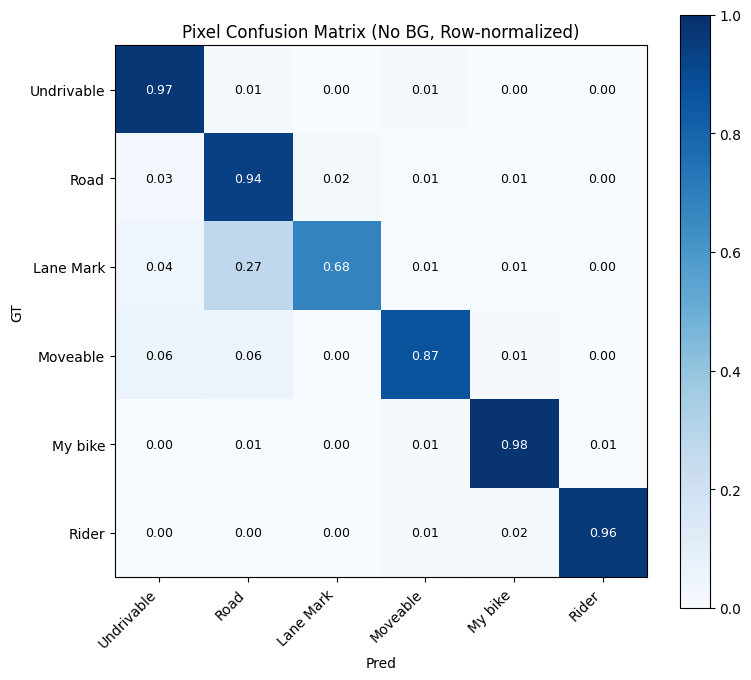

In [48]:
# =========================
# - loads BEST_PATH
# - computes: test_loss, test_mIoU(no-bg), laneIoU, per-class IoU (1..NUM_CLASSES-1)
# - (optional) pixel confusion matrix summary
# =========================

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# ---------- config ----------
BEST_PATH = "best_deeplabv3_r50_baseline_2.pt"

IGNORE_BG = True
PRINT_BG_IOU = False

LANE_TRAIN_ID = 3
TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55

# class weight/label smoothing은 "평가 loss" 계산용(학습과 동일 세팅 권장)
LABEL_SMOOTH = 0.0
use_class_weight = True
w = class_weights.to(DEVICE) if ("class_weights" in globals() and use_class_weight) else None

device = torch.device(DEVICE)

# ---------- class name map (train_id -> name) ----------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i+1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# ---------- model (same structure) ----------
model = deeplabv3_resnet50(weights=None, weights_backbone="DEFAULT")
model.classifier[4] = nn.Conv2d(256, NUM_CLASSES, kernel_size=1)
model.to(device)

# ---------- load best ----------
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
model.eval()

# ---------- loss (for reporting) ----------
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

# ---------- metrics ----------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate_test(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in tqdm(loader, desc="test", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["out"]  # (B,C,H,W)
        loss = criterion(out, y)
        total_loss += loss.item()
        n += 1

        pred = out.argmax(dim=1)  # (B,H,W)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist_f = hist.float()
    diag = torch.diag(hist_f)
    denom = (hist_f.sum(1) + hist_f.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    avg_loss = total_loss / max(n, 1)

    return avg_loss, miou, iou, hist.cpu().numpy()

# ---------- run test ----------
test_loss, test_miou, test_iou_pc, test_hist = evaluate_test(model, test_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou = float(test_iou_pc[LANE_TRAIN_ID])

tag = "no-bg" if IGNORE_BG else "with-bg"
print(f"[TEST] loss={test_loss:.4f} | mIoU({tag})={test_miou:.4f} | laneIoU(train_id={LANE_TRAIN_ID})={lane_iou:.4f}")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = test_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# =========================
# Confusion Matrix (Background 제거 → 6x6, 정규화 + 클래스 이름 표시)
# =========================

import numpy as np
import matplotlib.pyplot as plt

# background 제거
cm_no_bg = test_hist[1:, 1:].astype(np.float32)

# ✅ 행 기준 정규화 (GT 기준)
row_sum = cm_no_bg.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_no_bg, row_sum, where=row_sum != 0)

# ✅ 클래스 이름 추출 (1~NUM_CLASSES-1)
class_names = [train2name.get(i, str(i)) for i in range(1, NUM_CLASSES)]

plt.figure(figsize=(8, 7))
plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title("Pixel Confusion Matrix (No BG, Row-normalized)")
plt.xlabel("Pred")
plt.ylabel("GT")

# ---------- 숫자 표시 ----------
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i, f"{cm_norm[i,j]:.2f}",
            ha="center",
            va="center",
            color="white" if cm_norm[i,j] > 0.5 else "black",
            fontsize=9
        )

# ---------- 클래스 이름 적용 ----------
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

plt.colorbar()
plt.tight_layout()
plt.show()

## 4 DeepLabV3 + Lane Embedding Regularization 및 하이퍼파라미터 조정
#### (Multi-Head Segmentation Model) - LANE 보조헤드 추가(laneNet)

DEVICE=cuda | NUM_CLASSES=7 | IGNORE_BG_IN_mIoU=True | PATIENCE=5
LR=0.0003 | WD=0.0003 | label_smooth=0.0
LaneBoost: weight_x2.0 | Dice beta=0.3 | Emb lambda=0.02
EarlyStop score = mIoU + 0.5*laneIoU
Targets: mIoU>=0.85, LaneIoU>=0.55 (Lane id=3)
Save best to: best_deeplabv3_r50_laneemb_laneDice.pt



train:   0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\hugctx\AppData\Local\Temp\ipykernel_41028\2798210657.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)


[01] score=0.8676 | train=1.0012 (ce=0.7296, dice=0.9034, emb=0.0282) | val_loss=0.4522 | val_mIoU(no-bg)=0.7249 | laneIoU=0.2854
  IoU[1] Undrivable: 0.9054
  IoU[2] Road: 0.7588
  IoU[3] Lane Mark: 0.2854
  IoU[4] Moveable: 0.6523
  IoU[5] My bike: 0.8900
  IoU[6] Rider: 0.8572
  ✅ improved! best_score=0.8676 (mIoU=0.7249) @ epoch 1 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[02] score=0.8896 | train=0.5983 (ce=0.3769, dice=0.7378, emb=0.0025) | val_loss=0.4072 | val_mIoU(no-bg)=0.7419 | laneIoU=0.2954
  IoU[1] Undrivable: 0.9102
  IoU[2] Road: 0.7835
  IoU[3] Lane Mark: 0.2954
  IoU[4] Moveable: 0.6785
  IoU[5] My bike: 0.9051
  IoU[6] Rider: 0.8787
  ✅ improved! best_score=0.8896 (mIoU=0.7419) @ epoch 2 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[03] score=0.9367 | train=0.4607 (ce=0.2787, dice=0.6064, emb=0.0019) | val_loss=0.3913 | val_mIoU(no-bg)=0.7643 | laneIoU=0.3448
  IoU[1] Undrivable: 0.9225
  IoU[2] Road: 0.7945
  IoU[3] Lane Mark: 0.3448
  IoU[4] Moveable: 0.7357
  IoU[5] My bike: 0.9219
  IoU[6] Rider: 0.8668
  ✅ improved! best_score=0.9367 (mIoU=0.7643) @ epoch 3 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[04] score=0.9443 | train=0.3902 (ce=0.2366, dice=0.5121, emb=0.0013) | val_loss=0.3885 | val_mIoU(no-bg)=0.7787 | laneIoU=0.3312
  IoU[1] Undrivable: 0.9199
  IoU[2] Road: 0.8076
  IoU[3] Lane Mark: 0.3312
  IoU[4] Moveable: 0.7684
  IoU[5] My bike: 0.9327
  IoU[6] Rider: 0.9127
  ✅ improved! best_score=0.9443 (mIoU=0.7787) @ epoch 4 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[05] score=1.0089 | train=0.3491 (ce=0.2117, dice=0.4579, emb=0.0008) | val_loss=0.3686 | val_mIoU(no-bg)=0.7954 | laneIoU=0.4269
  IoU[1] Undrivable: 0.9167
  IoU[2] Road: 0.8235
  IoU[3] Lane Mark: 0.4269
  IoU[4] Moveable: 0.7404
  IoU[5] My bike: 0.9395
  IoU[6] Rider: 0.9254
  ✅ improved! best_score=1.0089 (mIoU=0.7954) @ epoch 5 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[06] score=1.0348 | train=0.3109 (ce=0.1875, dice=0.4111, emb=0.0005) | val_loss=0.3560 | val_mIoU(no-bg)=0.8101 | laneIoU=0.4494
  IoU[1] Undrivable: 0.9339
  IoU[2] Road: 0.8396
  IoU[3] Lane Mark: 0.4494
  IoU[4] Moveable: 0.7690
  IoU[5] My bike: 0.9435
  IoU[6] Rider: 0.9252
  ✅ improved! best_score=1.0348 (mIoU=0.8101) @ epoch 6 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[07] score=1.0454 | train=0.2854 (ce=0.1719, dice=0.3781, emb=0.0006) | val_loss=0.3667 | val_mIoU(no-bg)=0.8164 | laneIoU=0.4579
  IoU[1] Undrivable: 0.9381
  IoU[2] Road: 0.8535
  IoU[3] Lane Mark: 0.4579
  IoU[4] Moveable: 0.7849
  IoU[5] My bike: 0.9441
  IoU[6] Rider: 0.9200
  ✅ improved! best_score=1.0454 (mIoU=0.8164) @ epoch 7 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[08] score=1.0463 | train=0.2637 (ce=0.1581, dice=0.3522, emb=0.0005) | val_loss=0.3852 | val_mIoU(no-bg)=0.8156 | laneIoU=0.4615
  IoU[1] Undrivable: 0.9366
  IoU[2] Road: 0.8505
  IoU[3] Lane Mark: 0.4615
  IoU[4] Moveable: 0.7737
  IoU[5] My bike: 0.9439
  IoU[6] Rider: 0.9271
  ✅ improved! best_score=1.0463 (mIoU=0.8156) @ epoch 8 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[09] score=1.0594 | train=0.2519 (ce=0.1508, dice=0.3371, emb=0.0003) | val_loss=0.3723 | val_mIoU(no-bg)=0.8215 | laneIoU=0.4759
  IoU[1] Undrivable: 0.9393
  IoU[2] Road: 0.8558
  IoU[3] Lane Mark: 0.4759
  IoU[4] Moveable: 0.7801
  IoU[5] My bike: 0.9484
  IoU[6] Rider: 0.9291
  ✅ improved! best_score=1.0594 (mIoU=0.8215) @ epoch 9 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[10] score=1.0693 | train=0.2428 (ce=0.1439, dice=0.3296, emb=0.0003) | val_loss=0.4120 | val_mIoU(no-bg)=0.8253 | laneIoU=0.4880
  IoU[1] Undrivable: 0.9371
  IoU[2] Road: 0.8574
  IoU[3] Lane Mark: 0.4880
  IoU[4] Moveable: 0.7912
  IoU[5] My bike: 0.9498
  IoU[6] Rider: 0.9282
  ✅ improved! best_score=1.0693 (mIoU=0.8253) @ epoch 10 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[11] score=1.0665 | train=0.2323 (ce=0.1377, dice=0.3156, emb=0.0003) | val_loss=0.4034 | val_mIoU(no-bg)=0.8271 | laneIoU=0.4788
  IoU[1] Undrivable: 0.9404
  IoU[2] Road: 0.8608
  IoU[3] Lane Mark: 0.4788
  IoU[4] Moveable: 0.8001
  IoU[5] My bike: 0.9491
  IoU[6] Rider: 0.9330
  ❌ no improve | best_score=1.0693 @ epoch 10 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[12] score=1.0715 | train=0.2235 (ce=0.1323, dice=0.3041, emb=0.0003) | val_loss=0.4190 | val_mIoU(no-bg)=0.8272 | laneIoU=0.4886
  IoU[1] Undrivable: 0.9359
  IoU[2] Road: 0.8592
  IoU[3] Lane Mark: 0.4886
  IoU[4] Moveable: 0.7940
  IoU[5] My bike: 0.9499
  IoU[6] Rider: 0.9354
  ✅ improved! best_score=1.0715 (mIoU=0.8272) @ epoch 12 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[13] score=1.0711 | train=0.2163 (ce=0.1279, dice=0.2948, emb=0.0002) | val_loss=0.4247 | val_mIoU(no-bg)=0.8258 | laneIoU=0.4906
  IoU[1] Undrivable: 0.9360
  IoU[2] Road: 0.8588
  IoU[3] Lane Mark: 0.4906
  IoU[4] Moveable: 0.7818
  IoU[5] My bike: 0.9508
  IoU[6] Rider: 0.9368
  ❌ no improve | best_score=1.0715 @ epoch 12 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[14] score=1.0762 | train=0.2106 (ce=0.1243, dice=0.2875, emb=0.0002) | val_loss=0.4132 | val_mIoU(no-bg)=0.8300 | laneIoU=0.4924
  IoU[1] Undrivable: 0.9376
  IoU[2] Road: 0.8608
  IoU[3] Lane Mark: 0.4924
  IoU[4] Moveable: 0.7992
  IoU[5] My bike: 0.9515
  IoU[6] Rider: 0.9383
  ✅ improved! best_score=1.0762 (mIoU=0.8300) @ epoch 14 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[15] score=1.0784 | train=0.2055 (ce=0.1215, dice=0.2800, emb=0.0002) | val_loss=0.4533 | val_mIoU(no-bg)=0.8298 | laneIoU=0.4972
  IoU[1] Undrivable: 0.9375
  IoU[2] Road: 0.8640
  IoU[3] Lane Mark: 0.4972
  IoU[4] Moveable: 0.7918
  IoU[5] My bike: 0.9512
  IoU[6] Rider: 0.9373
  ✅ improved! best_score=1.0784 (mIoU=0.8298) @ epoch 15 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[16] score=1.0780 | train=0.2002 (ce=0.1183, dice=0.2730, emb=0.0002) | val_loss=0.4254 | val_mIoU(no-bg)=0.8303 | laneIoU=0.4954
  IoU[1] Undrivable: 0.9383
  IoU[2] Road: 0.8626
  IoU[3] Lane Mark: 0.4954
  IoU[4] Moveable: 0.7941
  IoU[5] My bike: 0.9507
  IoU[6] Rider: 0.9410
  ❌ no improve | best_score=1.0784 @ epoch 15 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[17] score=1.0838 | train=0.1950 (ce=0.1161, dice=0.2629, emb=0.0002) | val_loss=0.4292 | val_mIoU(no-bg)=0.8310 | laneIoU=0.5055
  IoU[1] Undrivable: 0.9393
  IoU[2] Road: 0.8647
  IoU[3] Lane Mark: 0.5055
  IoU[4] Moveable: 0.7880
  IoU[5] My bike: 0.9504
  IoU[6] Rider: 0.9382
  ✅ improved! best_score=1.0838 (mIoU=0.8310) @ epoch 17 | patience 0/5 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[18] score=1.0761 | train=0.1891 (ce=0.1129, dice=0.2538, emb=0.0002) | val_loss=0.4492 | val_mIoU(no-bg)=0.8285 | laneIoU=0.4952
  IoU[1] Undrivable: 0.9371
  IoU[2] Road: 0.8621
  IoU[3] Lane Mark: 0.4952
  IoU[4] Moveable: 0.7875
  IoU[5] My bike: 0.9504
  IoU[6] Rider: 0.9389
  ❌ no improve | best_score=1.0838 @ epoch 17 | patience 1/5 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[19] score=1.0816 | train=0.1859 (ce=0.1108, dice=0.2502, emb=0.0002) | val_loss=0.4495 | val_mIoU(no-bg)=0.8321 | laneIoU=0.4990
  IoU[1] Undrivable: 0.9384
  IoU[2] Road: 0.8638
  IoU[3] Lane Mark: 0.4990
  IoU[4] Moveable: 0.8002
  IoU[5] My bike: 0.9510
  IoU[6] Rider: 0.9403
  ❌ no improve | best_score=1.0838 @ epoch 17 | patience 2/5 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[20] score=1.0812 | train=0.1845 (ce=0.1092, dice=0.2510, emb=0.0001) | val_loss=0.4546 | val_mIoU(no-bg)=0.8315 | laneIoU=0.4994
  IoU[1] Undrivable: 0.9384
  IoU[2] Road: 0.8652
  IoU[3] Lane Mark: 0.4994
  IoU[4] Moveable: 0.7930
  IoU[5] My bike: 0.9519
  IoU[6] Rider: 0.9410
  ❌ no improve | best_score=1.0838 @ epoch 17 | patience 3/5 (remain 2)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[21] score=1.0723 | train=0.1809 (ce=0.1077, dice=0.2443, emb=0.0001) | val_loss=0.4780 | val_mIoU(no-bg)=0.8290 | laneIoU=0.4867
  IoU[1] Undrivable: 0.9384
  IoU[2] Road: 0.8654
  IoU[3] Lane Mark: 0.4867
  IoU[4] Moveable: 0.7906
  IoU[5] My bike: 0.9513
  IoU[6] Rider: 0.9417
  ❌ no improve | best_score=1.0838 @ epoch 17 | patience 4/5 (remain 1)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[22] score=1.0791 | train=0.1783 (ce=0.1059, dice=0.2412, emb=0.0001) | val_loss=0.4720 | val_mIoU(no-bg)=0.8304 | laneIoU=0.4973
  IoU[1] Undrivable: 0.9381
  IoU[2] Road: 0.8650
  IoU[3] Lane Mark: 0.4973
  IoU[4] Moveable: 0.7908
  IoU[5] My bike: 0.9516
  IoU[6] Rider: 0.9397
  ❌ no improve | best_score=1.0838 @ epoch 17 | patience 5/5 (remain 0)

Early stopping triggered.
Best epoch=17 | best_score=1.083785 | best_mIoU=0.831025

[Best Model @ VAL]
val_loss=0.4292 | val_mIoU(no-bg)=0.8310 | laneIoU=0.5055 | score=1.0838
  IoU[1] Undrivable: 0.9393
  IoU[2] Road: 0.8647
  IoU[3] Lane Mark: 0.5055
  IoU[4] Moveable: 0.7880
  IoU[5] My bike: 0.9504
  IoU[6] Rider: 0.9382


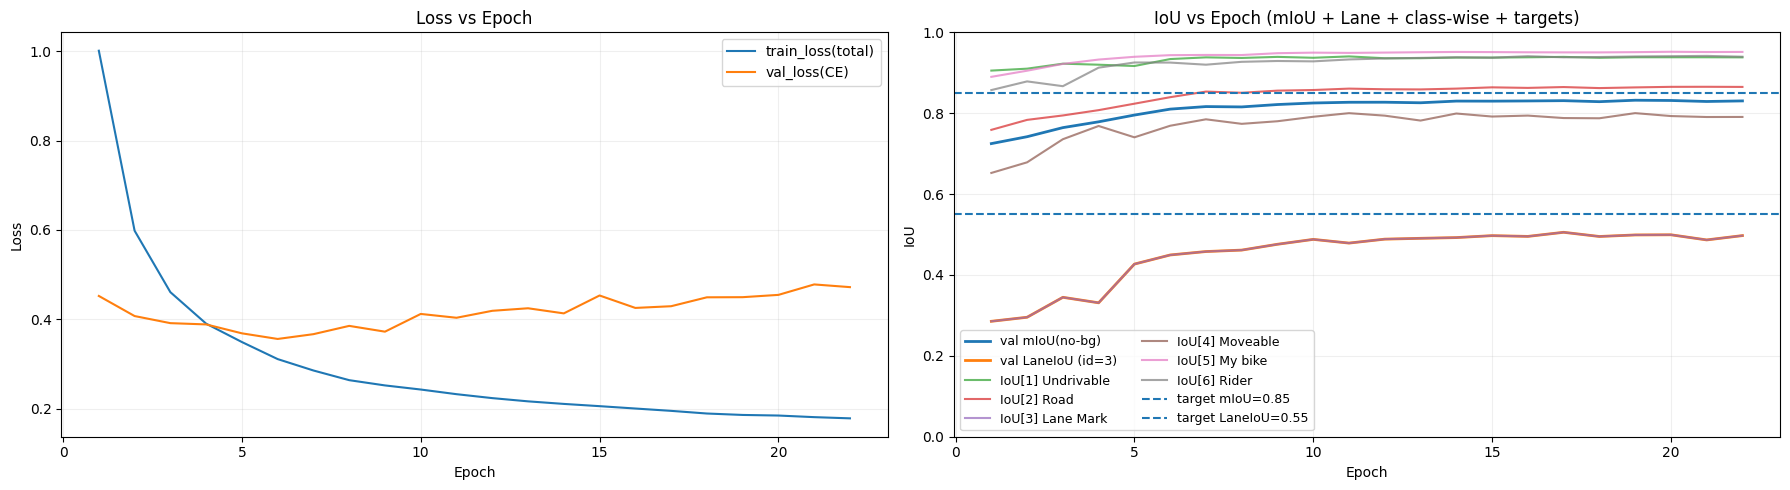

In [64]:
# ============================================================
# DeepLabV3+ResNet50 + Lane Embedding Head (Aux branch)
# - (1) Lane Embedding head 모델 ✅
# - (2) loss 연결(SEG + λ*EMB) ✅
# - (3) 기존 출력/가시화/early stopping(mIoU no-bg) 유지 ✅
#
# [정칙화/안전 장치]
# - WEIGHT_DECAY=3e-4 (기존 유지)
# - Lane Embedding loss는 "아주 약하게" 시작: LAMBDA_EMB=0.02 (망가지면 0.01/0.005)
# - Embedding loss는 lane 픽셀 적으면 batch skip
#
# [필수로 이미 존재해야 하는 것]
# - DEVICE (e.g., "cuda"), NUM_CLASSES=7
# - train_loader, val_loader
# - coco (선택: class name 매핑용)
# - id2train (저장용; 없으면 저장 dict에서 빠짐)
# - class_weights (선택: 이미 계산해둔 weight 재사용)
# ============================================================
# ============================================================
# DeepLabV3+ResNet50 + Lane Embedding Head (Aux) + Lane Dice
# - EarlyStopping 점수: score = val_mIoU(no-bg) + ALPHA_LANE * laneIoU  ✅
# - class weight: lane만 BOOST (LANE_WEIGHT_BOOST) ✅
# - seg loss: CE + BETA_DICE * Dice(lane) ✅
# - emb loss: (기존) pull + 약한 push 유지 ✅
# - 출력/가시화(좌우 Loss/IoU) 유지 ✅
#
# [필수 전제(이미 존재해야 함)]
# - DEVICE (e.g., "cuda"), NUM_CLASSES (=7)
# - train_loader, val_loader
# - class_weights (없으면 None로 진행)
# - coco (선택: class name 표시용)
# - id2train (선택: 저장에 포함)
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# --------------------
# CONFIG
# --------------------
EPOCHS = 30
PATIENCE = 5

LR = 3e-4
WEIGHT_DECAY = 3e-4
LABEL_SMOOTH = 0.0

BEST_PATH = "best_deeplabv3_r50_laneemb_laneDice.pt"

IGNORE_BG = True
PRINT_BG_IOU = False

TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55
LANE_TRAIN_ID = 3

# ---- Lane Embedding branch ----
EMB_DIM = 4
LAMBDA_EMB = 0.02          # 안전 시작값
EMB_MARGIN = 1.0
EMB_MIN_PIXELS = 30        # lane 픽셀 적으면 emb loss skip

# ---- Lane Dice (Lane 얇은 클래스에 특효) ----
BETA_DICE = 0.3            # 0.2~0.5 권장 (lane만 적용)
DICE_SMOOTH = 1.0

# ---- class weight lane boost (가장 쉬운 개선) ----
LANE_WEIGHT_BOOST = 2.0    # 1.5~2.5 권장

# ---- EarlyStopping score = mIoU + alpha*laneIoU (lane를 반영) ----
ALPHA_LANE = 0.5           # 0.3~0.7 권장

# (선택) backbone warmup freeze
FREEZE_BACKBONE_WARMUP_EPOCHS = 0

device = torch.device(DEVICE)

# --------------------
# CLASS NAME MAP
# --------------------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i + 1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# --------------------
# MODEL: DeepLabV3 + Lane Embedding Head
# --------------------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    """
    out["seg"]: (B, num_classes, H, W)
    out["emb"]: (B, emb_dim, H, W)
    """
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )

        # DeepLabHead는 nn.Sequential subclass라 slicing이 꼬일 수 있음 → children으로 재구성
        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]                         # (B,C,h,w)

        feat256 = self.feat_extractor(x_out)         # (B,256,h,w)
        seg = self.seg_head(feat256)                 # (B,num_classes,h,w)
        emb = self.embed_head(feat256)               # (B,emb_dim,h,w)

        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

# --------------------
# LOSS: Embedding regularization (안전 버전)
# --------------------
def lane_embedding_loss_simple(emb, y, lane_id: int, margin: float = 1.0, min_pixels: int = 30):
    """
    - pull: lane 픽셀 임베딩을 lane_mean으로 응집
    - push: lane_mean과 non_mean이 margin 이상 떨어지도록(약하게)
    """
    B, D, H, W = emb.shape
    emb_hw = emb.permute(0, 2, 3, 1).contiguous().view(B, H * W, D)
    y_hw = y.view(B, H * W)

    total = emb.new_tensor(0.0)
    cnt = 0

    for b in range(B):
        lane_mask = (y_hw[b] == lane_id)
        non_mask = ~lane_mask

        if lane_mask.sum() < min_pixels or non_mask.sum() < min_pixels:
            continue

        lane_emb = emb_hw[b][lane_mask]
        non_emb = emb_hw[b][non_mask]

        lane_mean = lane_emb.mean(dim=0, keepdim=True)
        non_mean = non_emb.mean(dim=0, keepdim=True)

        pull = F.mse_loss(lane_emb, lane_mean.expand_as(lane_emb))
        dist = torch.norm(lane_mean - non_mean, p=2)
        push = F.relu(margin - dist)

        total = total + (pull + 0.1 * push)
        cnt += 1

    if cnt == 0:
        return emb.new_tensor(0.0)
    return total / cnt

# --------------------
# LOSS: Lane Dice (lane class만)
# --------------------
def lane_dice_loss(seg_logits, y, lane_id: int, smooth: float = 1.0):
    """
    seg_logits: (B,C,H,W)
    y        : (B,H,W)
    -> lane class에 대해서만 soft dice loss
    """
    probs = torch.softmax(seg_logits, dim=1)[:, lane_id, :, :]  # (B,H,W)
    gt = (y == lane_id).float()                                 # (B,H,W)

    # flatten
    probs = probs.reshape(probs.size(0), -1)
    gt = gt.reshape(gt.size(0), -1)

    inter = (probs * gt).sum(dim=1)
    denom = probs.sum(dim=1) + gt.sum(dim=1)

    dice = (2.0 * inter + smooth) / (denom + smooth)
    return 1.0 - dice.mean()

# --------------------
# CRITERION (CE) + lane weight boost
# --------------------
use_class_weight = True
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
if w is not None:
    w = w.clone()
    if 0 <= LANE_TRAIN_ID < len(w):
        w[LANE_TRAIN_ID] = w[LANE_TRAIN_ID] * LANE_WEIGHT_BOOST

criterion_ce = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

def total_loss_fn(out, y):
    seg_logits = out["seg"]
    emb = out["emb"]

    loss_ce = criterion_ce(seg_logits, y)
    loss_dice = lane_dice_loss(seg_logits, y, lane_id=LANE_TRAIN_ID, smooth=DICE_SMOOTH)
    loss_emb = lane_embedding_loss_simple(emb, y, lane_id=LANE_TRAIN_ID, margin=EMB_MARGIN, min_pixels=EMB_MIN_PIXELS)

    loss_total = loss_ce + BETA_DICE * loss_dice + LAMBDA_EMB * loss_emb
    return loss_total, loss_ce.detach(), loss_dice.detach(), loss_emb.detach()

# --------------------
# OPT / SCHED
# --------------------
model = DeepLabV3_WithLaneEmbedding(NUM_CLASSES, EMB_DIM, backbone_pretrained=True, dropout_p=0.1).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

def set_backbone_trainable(model, trainable: bool):
    for p in model.base.backbone.parameters():
        p.requires_grad = trainable

# --------------------
# METRICS
# --------------------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        seg_logits = model(x)["seg"]
        loss = criterion_ce(seg_logits, y)  # val loss는 seg만(기존 유지)
        total_loss += float(loss.item())
        n += 1

        pred = seg_logits.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist = hist.float()
    diag = torch.diag(hist)
    denom = (hist.sum(1) + hist.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    return total_loss / max(n, 1), miou, iou

def train_one_epoch(model, loader):
    model.train()
    total = 0.0
    ce_sum = 0.0
    dice_sum = 0.0
    emb_sum = 0.0
    n = 0

    for x, y in tqdm(loader, desc="train", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)
        loss_total, loss_ce, loss_dice, loss_emb = total_loss_fn(out, y)

        optimizer.zero_grad(set_to_none=True)
        loss_total.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total += float(loss_total.item())
        ce_sum += float(loss_ce.item())
        dice_sum += float(loss_dice.item())
        emb_sum += float(loss_emb.item())
        n += 1

    return total / max(n, 1), ce_sum / max(n, 1), dice_sum / max(n, 1), emb_sum / max(n, 1)

# --------------------
# HISTORY
# --------------------
history = {
    "epoch": [],
    "train_total": [],
    "train_ce": [],
    "train_dice": [],
    "train_emb": [],
    "val_loss": [],
    "val_miou": [],
    "val_iou_per_class": [],
    "val_score": [],
}

# --------------------
# TRAIN LOOP (EarlyStopping: score = mIoU + alpha*lane)
# --------------------
best_score = -1e9
best_epoch = 0
best_miou = -1.0
pat = 0

print(f"DEVICE={DEVICE} | NUM_CLASSES={NUM_CLASSES} | IGNORE_BG_IN_mIoU={IGNORE_BG} | PATIENCE={PATIENCE}")
print(f"LR={LR} | WD={WEIGHT_DECAY} | label_smooth={LABEL_SMOOTH}")
print(f"LaneBoost: weight_x{LANE_WEIGHT_BOOST} | Dice beta={BETA_DICE} | Emb lambda={LAMBDA_EMB}")
print(f"EarlyStop score = mIoU + {ALPHA_LANE}*laneIoU")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU} (Lane id={LANE_TRAIN_ID})")
print(f"Save best to: {BEST_PATH}\n")

for epoch in range(1, EPOCHS + 1):
    if FREEZE_BACKBONE_WARMUP_EPOCHS > 0:
        set_backbone_trainable(model, trainable=(epoch > FREEZE_BACKBONE_WARMUP_EPOCHS))

    tr_total, tr_ce, tr_dice, tr_emb = train_one_epoch(model, train_loader)
    va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
    scheduler.step()

    lane_iou = float(va_iou_pc[LANE_TRAIN_ID])
    va_score = float(va_miou + ALPHA_LANE * lane_iou)

    history["epoch"].append(epoch)
    history["train_total"].append(tr_total)
    history["train_ce"].append(tr_ce)
    history["train_dice"].append(tr_dice)
    history["train_emb"].append(tr_emb)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["val_iou_per_class"].append(va_iou_pc)
    history["val_score"].append(va_score)

    tag = "no-bg" if IGNORE_BG else "with-bg"
    print(f"[{epoch:02d}] score={va_score:.4f} | train={tr_total:.4f} (ce={tr_ce:.4f}, dice={tr_dice:.4f}, emb={tr_emb:.4f}) "
          f"| val_loss={va_loss:.4f} | val_mIoU({tag})={va_miou:.4f} | laneIoU={lane_iou:.4f}")

    start_cid = 0 if PRINT_BG_IOU else 1
    for cid in range(start_cid, NUM_CLASSES):
        name = train2name.get(cid, str(cid))
        v = va_iou_pc[cid]
        txt = "nan" if np.isnan(v) else f"{v:.4f}"
        print(f"  IoU[{cid}] {name}: {txt}")

    improved = va_score > best_score + 1e-7
    if improved:
        best_score = va_score
        best_epoch = epoch
        best_miou = va_miou
        pat = 0
        save_dict = {"model": model.state_dict(), "num_classes": NUM_CLASSES}
        if "id2train" in globals():
            save_dict["id2train"] = id2train
        torch.save(save_dict, BEST_PATH)
        print(f"  ✅ improved! best_score={best_score:.4f} (mIoU={best_miou:.4f}) @ epoch {best_epoch} | patience {pat}/{PATIENCE} | saved\n")
    else:
        pat += 1
        remain = PATIENCE - pat
        print(f"  ❌ no improve | best_score={best_score:.4f} @ epoch {best_epoch} | patience {pat}/{PATIENCE} (remain {max(remain,0)})\n")
        if pat >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Best epoch={best_epoch} | best_score={best_score:.6f} | best_mIoU={best_miou:.6f}")

# --------------------
# LOAD BEST + FINAL VAL REPORT
# --------------------
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou_best = float(va_iou_pc[LANE_TRAIN_ID])
va_score_best = float(va_miou + ALPHA_LANE * lane_iou_best)

print("\n[Best Model @ VAL]")
print(f"val_loss={va_loss:.4f} | val_mIoU({'no-bg' if IGNORE_BG else 'with-bg'})={va_miou:.4f} | laneIoU={lane_iou_best:.4f} | score={va_score_best:.4f}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = va_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# --------------------
# VISUALIZATION: SIDE-BY-SIDE (Loss / IoU)
# --------------------
epochs = np.array(history["epoch"])
train_total = np.array(history["train_total"])
val_loss_arr = np.array(history["val_loss"])
val_miou_hist = np.array(history["val_miou"])
val_iou_stack = np.stack(history["val_iou_per_class"], axis=0)
lane_iou_hist = val_iou_stack[:, LANE_TRAIN_ID]

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# (좌) Loss
axes[0].plot(epochs, train_total, label="train_loss(total)")
axes[0].plot(epochs, val_loss_arr, label="val_loss(CE)")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Epoch")
axes[0].grid(True, alpha=0.2)
axes[0].legend()

# (우) IoU
axes[1].plot(epochs, val_miou_hist, linewidth=2, label=("val mIoU(no-bg)" if IGNORE_BG else "val mIoU"))
axes[1].plot(epochs, lane_iou_hist, linewidth=2, label=f"val LaneIoU (id={LANE_TRAIN_ID})")

for cid in range(1, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    axes[1].plot(epochs, val_iou_stack[:, cid], alpha=0.7, label=f"IoU[{cid}] {name}")

axes[1].axhline(TARGET_MIOU, linestyle="--", linewidth=1.5, label=f"target mIoU={TARGET_MIOU}")
axes[1].axhline(TARGET_LANE_IOU, linestyle="--", linewidth=1.5, label=f"target LaneIoU={TARGET_LANE_IOU}")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("IoU")
axes[1].set_title("IoU vs Epoch (mIoU + Lane + class-wise + targets)")
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.2)
axes[1].legend(ncol=2, fontsize=9)

plt.tight_layout()
plt.show()

test:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\hugctx\AppData\Local\Temp\ipykernel_41028\2798210657.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)


[TEST] loss=0.4589 | mIoU(no-bg)=0.8019 | laneIoU(train_id=3)=0.4837
Targets: mIoU>=0.85, LaneIoU>=0.55
  IoU[1] Undrivable: 0.9459
  IoU[2] Road: 0.8639
  IoU[3] Lane Mark: 0.4837
  IoU[4] Moveable: 0.6405
  IoU[5] My bike: 0.9417
  IoU[6] Rider: 0.9361


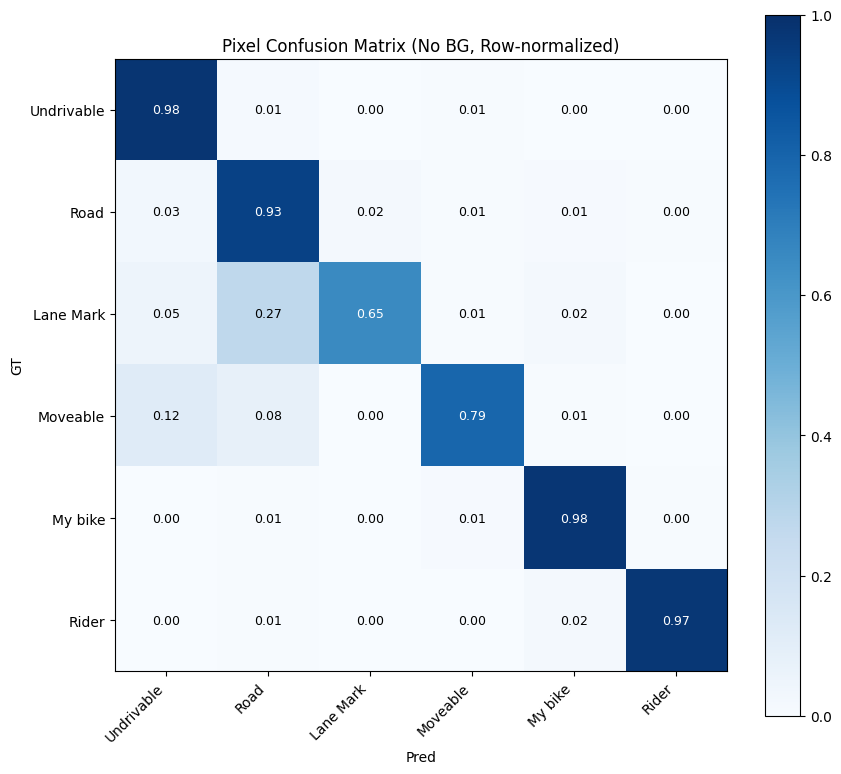

In [72]:
# ============================================================
# DeepLabV3+ResNet50 + Lane Embedding Head (Aux) + LaneDice 학습모델 평가
# - loads BEST_PATH
# - computes: test_loss(CE), test_mIoU(no-bg), laneIoU, per-class IoU
# - confusion matrix: no-bg(6x6), row-normalized + class names
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# ---------- config ----------
BEST_PATH = "best_deeplabv3_r50_laneemb_laneDice.pt"  # ✅ 학습 때 저장한 best로 바꾸세요

IGNORE_BG = True
PRINT_BG_IOU = False

LANE_TRAIN_ID = 3
TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55

LABEL_SMOOTH = 0.0
use_class_weight = True

device = torch.device(DEVICE)

# ---------- class name map (train_id -> name) ----------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i + 1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# ---------- model: DeepLabV3 + Lane Embedding ----------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    """
    out["seg"]: (B, num_classes, H, W)
    out["emb"]: (B, emb_dim, H, W)  # 테스트에서는 emb는 사용 안 해도 됨
    """
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )

        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]
        feat256 = self.feat_extractor(x_out)
        seg = self.seg_head(feat256)
        emb = self.embed_head(feat256)

        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

# ---------- loss (for reporting) ----------
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

# ---------- load best ----------
ckpt = torch.load(BEST_PATH, map_location=device)

# emb_dim 추론(ckpt에 없으면 기본 4로)
EMB_DIM = int(ckpt.get("emb_dim", 4)) if isinstance(ckpt, dict) else 4

model = DeepLabV3_WithLaneEmbedding(
    num_classes=NUM_CLASSES,
    emb_dim=EMB_DIM,
    backbone_pretrained=True,
    dropout_p=0.1
).to(device)

# 저장 포맷 방어: {"model": state_dict} or state_dict 직접 저장
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state, strict=True)
model.eval()

# ---------- metrics ----------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate_test(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in tqdm(loader, desc="test", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["seg"]  # ✅ 새 모델은 "seg"
        loss = criterion(out, y)
        total_loss += float(loss.item())
        n += 1

        pred = out.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist_f = hist.float()
    diag = torch.diag(hist_f)
    denom = (hist_f.sum(1) + hist_f.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    avg_loss = total_loss / max(n, 1)

    return avg_loss, miou, iou, hist.cpu().numpy()

# ---------- run test ----------
test_loss, test_miou, test_iou_pc, test_hist = evaluate_test(model, test_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou = float(test_iou_pc[LANE_TRAIN_ID])

tag = "no-bg" if IGNORE_BG else "with-bg"
print(f"[TEST] loss={test_loss:.4f} | mIoU({tag})={test_miou:.4f} | laneIoU(train_id={LANE_TRAIN_ID})={lane_iou:.4f}")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = test_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# ============================================================
# Confusion Matrix (No BG: (NUM_CLASSES-1)x(NUM_CLASSES-1))
# Row-normalized (GT 기준) + 클래스 이름 + 숫자 표시
# ============================================================

cm_no_bg = test_hist[1:, 1:].astype(np.float32)

row_sum = cm_no_bg.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_no_bg, row_sum, where=row_sum != 0)

class_names = [train2name.get(i, str(i)) for i in range(1, NUM_CLASSES)]

plt.figure(figsize=(9, 8))
plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title("Pixel Confusion Matrix (No BG, Row-normalized)")
plt.xlabel("Pred")
plt.ylabel("GT")

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i, f"{cm_norm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black",
            fontsize=9
        )

plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

plt.colorbar()
plt.tight_layout()
plt.show()


test:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\hugctx\AppData\Local\Temp\ipykernel_41028\2798210657.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)


[TEST] loss=0.4490 | mIoU(no-bg)=0.7988 | laneIoU(train_id=3)=0.4616
Targets: mIoU>=0.85, LaneIoU>=0.55
  IoU[1] Undrivable: 0.9439
  IoU[2] Road: 0.8531
  IoU[3] Lane Mark: 0.4616
  IoU[4] Moveable: 0.6616
  IoU[5] My bike: 0.9425
  IoU[6] Rider: 0.9299


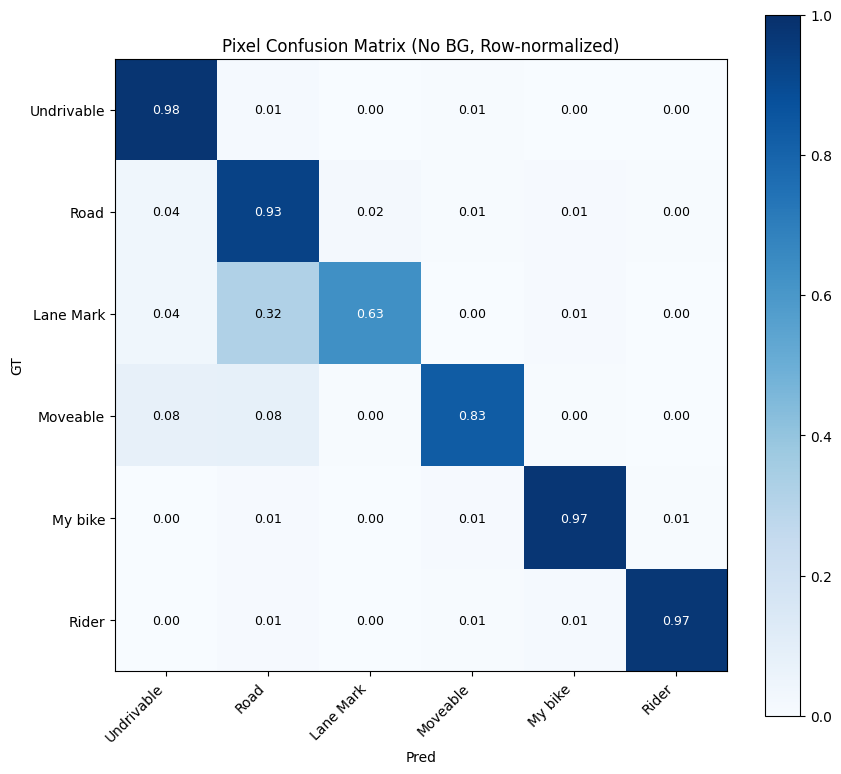

In [82]:
# ============================================================
# DeepLabV3+ResNet50 + Lane Embedding Head (Aux) + LaneDice 학습모델 평가
# - loads BEST_PATH
# - computes: test_loss(CE), test_mIoU(no-bg), laneIoU, per-class IoU
# - confusion matrix: no-bg(6x6), row-normalized + class names
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# ---------- config ----------
BEST_PATH = "best_deeplabv3_r50_laneemb_laneDice_vnext.pt"
#BEST_PATH = "best_deeplabv3_r50_lane_vnext2.pt"  # ✅ 학습 때 저장한 best로 바꾸세요

IGNORE_BG = True
PRINT_BG_IOU = False

LANE_TRAIN_ID = 3
TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55

LABEL_SMOOTH = 0.0
use_class_weight = True

device = torch.device(DEVICE)

# ---------- class name map (train_id -> name) ----------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i + 1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# ---------- model: DeepLabV3 + Lane Embedding ----------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    """
    out["seg"]: (B, num_classes, H, W)
    out["emb"]: (B, emb_dim, H, W)  # 테스트에서는 emb는 사용 안 해도 됨
    """
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )

        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]
        feat256 = self.feat_extractor(x_out)
        seg = self.seg_head(feat256)
        emb = self.embed_head(feat256)

        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

# ---------- loss (for reporting) ----------
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

# ---------- load best ----------
ckpt = torch.load(BEST_PATH, map_location=device)

# emb_dim 추론(ckpt에 없으면 기본 4로)
EMB_DIM = int(ckpt.get("emb_dim", 4)) if isinstance(ckpt, dict) else 4

model = DeepLabV3_WithLaneEmbedding(
    num_classes=NUM_CLASSES,
    emb_dim=EMB_DIM,
    backbone_pretrained=True,
    dropout_p=0.1
).to(device)

# 저장 포맷 방어: {"model": state_dict} or state_dict 직접 저장
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state, strict=True)
model.eval()

# ---------- metrics ----------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate_test(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in tqdm(loader, desc="test", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["seg"]  # ✅ 새 모델은 "seg"
        loss = criterion(out, y)
        total_loss += float(loss.item())
        n += 1

        pred = out.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist_f = hist.float()
    diag = torch.diag(hist_f)
    denom = (hist_f.sum(1) + hist_f.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    avg_loss = total_loss / max(n, 1)

    return avg_loss, miou, iou, hist.cpu().numpy()

# ---------- run test ----------
test_loss, test_miou, test_iou_pc, test_hist = evaluate_test(model, test_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou = float(test_iou_pc[LANE_TRAIN_ID])

tag = "no-bg" if IGNORE_BG else "with-bg"
print(f"[TEST] loss={test_loss:.4f} | mIoU({tag})={test_miou:.4f} | laneIoU(train_id={LANE_TRAIN_ID})={lane_iou:.4f}")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = test_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# ============================================================
# Confusion Matrix (No BG: (NUM_CLASSES-1)x(NUM_CLASSES-1))
# Row-normalized (GT 기준) + 클래스 이름 + 숫자 표시
# ============================================================

cm_no_bg = test_hist[1:, 1:].astype(np.float32)

row_sum = cm_no_bg.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_no_bg, row_sum, where=row_sum != 0)

class_names = [train2name.get(i, str(i)) for i in range(1, NUM_CLASSES)]

plt.figure(figsize=(9, 8))
plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title("Pixel Confusion Matrix (No BG, Row-normalized)")
plt.xlabel("Pred")
plt.ylabel("GT")

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i, f"{cm_norm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black",
            fontsize=9
        )

plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

plt.colorbar()
plt.tight_layout()
plt.show()


DEVICE=cuda | NUM_CLASSES=7 | LR=0.0002 | WD=0.0003
LaneDice schedule: 0.2->0.4->0.6 @ ep 5/15
Score = mIoU + 0.5*LaneIoU | Lane id=3
Save best to: best_deeplabv3_r50_laneemb_laneDice_vnext.pt



train:   0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\hugctx\AppData\Local\Temp\ipykernel_41028\2798210657.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)


[01] lr=2.00e-04 | w_dice=0.20 | score=0.8555 | train=0.9281 (ce=0.7345, dice=0.9645, emb=0.0322) | val_loss=0.4564 | val_mIoU(no-bg)=0.7222 | laneIoU=0.2667
  IoU[1] Undrivable: 0.9111
  IoU[2] Road: 0.7473
  IoU[3] Lane Mark: 0.2667
  IoU[4] Moveable: 0.7166
  IoU[5] My bike: 0.8571
  IoU[6] Rider: 0.8342
  ✅ improved! best_score=0.8555 (mIoU=0.7222) @ epoch 1 | patience 0/6 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[02] lr=2.00e-04 | w_dice=0.20 | score=0.9341 | train=0.5629 (ce=0.3744, dice=0.9423, emb=0.0034) | val_loss=0.3515 | val_mIoU(no-bg)=0.7606 | laneIoU=0.3469
  IoU[1] Undrivable: 0.9115
  IoU[2] Road: 0.8034
  IoU[3] Lane Mark: 0.3469
  IoU[4] Moveable: 0.6905
  IoU[5] My bike: 0.9192
  IoU[6] Rider: 0.8923
  ✅ improved! best_score=0.9341 (mIoU=0.7606) @ epoch 2 | patience 0/6 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[03] lr=1.99e-04 | w_dice=0.20 | score=0.9291 | train=0.4607 (ce=0.2773, dice=0.9170, emb=0.0020) | val_loss=0.3118 | val_mIoU(no-bg)=0.7759 | laneIoU=0.3064
  IoU[1] Undrivable: 0.9326
  IoU[2] Road: 0.7997
  IoU[3] Lane Mark: 0.3064
  IoU[4] Moveable: 0.7761
  IoU[5] My bike: 0.9338
  IoU[6] Rider: 0.9072
  ❌ no improve | best_score=0.9341 @ epoch 2 | patience 1/6 (remain 5)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[04] lr=1.97e-04 | w_dice=0.20 | score=0.9647 | train=0.4066 (ce=0.2311, dice=0.8778, emb=0.0009) | val_loss=0.3125 | val_mIoU(no-bg)=0.7850 | laneIoU=0.3596
  IoU[1] Undrivable: 0.9322
  IoU[2] Road: 0.8312
  IoU[3] Lane Mark: 0.3596
  IoU[4] Moveable: 0.7440
  IoU[5] My bike: 0.9334
  IoU[6] Rider: 0.9094
  ✅ improved! best_score=0.9647 (mIoU=0.7850) @ epoch 4 | patience 0/6 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[05] lr=1.95e-04 | w_dice=0.20 | score=1.0028 | train=0.3652 (ce=0.2024, dice=0.8139, emb=0.0008) | val_loss=0.2921 | val_mIoU(no-bg)=0.8040 | laneIoU=0.3977
  IoU[1] Undrivable: 0.9397
  IoU[2] Road: 0.8425
  IoU[3] Lane Mark: 0.3977
  IoU[4] Moveable: 0.7801
  IoU[5] My bike: 0.9442
  IoU[6] Rider: 0.9196
  ✅ improved! best_score=1.0028 (mIoU=0.8040) @ epoch 5 | patience 0/6 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[06] lr=1.92e-04 | w_dice=0.40 | score=1.0179 | train=0.4674 (ce=0.1874, dice=0.7000, emb=0.0007) | val_loss=0.3116 | val_mIoU(no-bg)=0.8078 | laneIoU=0.4202
  IoU[1] Undrivable: 0.9410
  IoU[2] Road: 0.8475
  IoU[3] Lane Mark: 0.4202
  IoU[4] Moveable: 0.7783
  IoU[5] My bike: 0.9427
  IoU[6] Rider: 0.9170
  ✅ improved! best_score=1.0179 (mIoU=0.8078) @ epoch 6 | patience 0/6 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[07] lr=1.89e-04 | w_dice=0.40 | score=1.0112 | train=0.4090 (ce=0.1854, dice=0.5590, emb=0.0007) | val_loss=0.3563 | val_mIoU(no-bg)=0.8082 | laneIoU=0.4060
  IoU[1] Undrivable: 0.9420
  IoU[2] Road: 0.8534
  IoU[3] Lane Mark: 0.4060
  IoU[4] Moveable: 0.7829
  IoU[5] My bike: 0.9461
  IoU[6] Rider: 0.9186
  ❌ no improve | best_score=1.0179 @ epoch 6 | patience 1/6 (remain 5)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[08] lr=1.85e-04 | w_dice=0.40 | score=1.0404 | train=0.3713 (ce=0.1800, dice=0.4781, emb=0.0006) | val_loss=0.3403 | val_mIoU(no-bg)=0.8156 | laneIoU=0.4495
  IoU[1] Undrivable: 0.9374
  IoU[2] Road: 0.8514
  IoU[3] Lane Mark: 0.4495
  IoU[4] Moveable: 0.7894
  IoU[5] My bike: 0.9440
  IoU[6] Rider: 0.9220
  ✅ improved! best_score=1.0404 (mIoU=0.8156) @ epoch 8 | patience 0/6 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[09] lr=1.80e-04 | w_dice=0.40 | score=1.0479 | train=0.3361 (ce=0.1680, dice=0.4202, emb=0.0005) | val_loss=0.3286 | val_mIoU(no-bg)=0.8181 | laneIoU=0.4597
  IoU[1] Undrivable: 0.9427
  IoU[2] Road: 0.8597
  IoU[3] Lane Mark: 0.4597
  IoU[4] Moveable: 0.7784
  IoU[5] My bike: 0.9472
  IoU[6] Rider: 0.9210
  ✅ improved! best_score=1.0479 (mIoU=0.8181) @ epoch 9 | patience 0/6 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[10] lr=1.75e-04 | w_dice=0.40 | score=1.0683 | train=0.3105 (ce=0.1572, dice=0.3832, emb=0.0004) | val_loss=0.3232 | val_mIoU(no-bg)=0.8264 | laneIoU=0.4837
  IoU[1] Undrivable: 0.9429
  IoU[2] Road: 0.8631
  IoU[3] Lane Mark: 0.4837
  IoU[4] Moveable: 0.7987
  IoU[5] My bike: 0.9457
  IoU[6] Rider: 0.9242
  ✅ improved! best_score=1.0683 (mIoU=0.8264) @ epoch 10 | patience 0/6 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[11] lr=1.69e-04 | w_dice=0.40 | score=1.0655 | train=0.2937 (ce=0.1497, dice=0.3600, emb=0.0003) | val_loss=0.3185 | val_mIoU(no-bg)=0.8274 | laneIoU=0.4761
  IoU[1] Undrivable: 0.9478
  IoU[2] Road: 0.8649
  IoU[3] Lane Mark: 0.4761
  IoU[4] Moveable: 0.7980
  IoU[5] My bike: 0.9487
  IoU[6] Rider: 0.9288
  ❌ no improve | best_score=1.0683 @ epoch 10 | patience 1/6 (remain 5)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[12] lr=1.63e-04 | w_dice=0.40 | score=1.0642 | train=0.2773 (ce=0.1418, dice=0.3388, emb=0.0002) | val_loss=0.3427 | val_mIoU(no-bg)=0.8248 | laneIoU=0.4787
  IoU[1] Undrivable: 0.9407
  IoU[2] Road: 0.8609
  IoU[3] Lane Mark: 0.4787
  IoU[4] Moveable: 0.7905
  IoU[5] My bike: 0.9483
  IoU[6] Rider: 0.9298
  ❌ no improve | best_score=1.0683 @ epoch 10 | patience 2/6 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[13] lr=1.57e-04 | w_dice=0.40 | score=1.0743 | train=0.2654 (ce=0.1367, dice=0.3217, emb=0.0002) | val_loss=0.3387 | val_mIoU(no-bg)=0.8299 | laneIoU=0.4889
  IoU[1] Undrivable: 0.9492
  IoU[2] Road: 0.8679
  IoU[3] Lane Mark: 0.4889
  IoU[4] Moveable: 0.7968
  IoU[5] My bike: 0.9488
  IoU[6] Rider: 0.9278
  ✅ improved! best_score=1.0743 (mIoU=0.8299) @ epoch 13 | patience 0/6 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[14] lr=1.50e-04 | w_dice=0.40 | score=1.0689 | train=0.2574 (ce=0.1313, dice=0.3153, emb=0.0002) | val_loss=0.3403 | val_mIoU(no-bg)=0.8284 | laneIoU=0.4811
  IoU[1] Undrivable: 0.9418
  IoU[2] Road: 0.8657
  IoU[3] Lane Mark: 0.4811
  IoU[4] Moveable: 0.7945
  IoU[5] My bike: 0.9502
  IoU[6] Rider: 0.9371
  ❌ no improve | best_score=1.0743 @ epoch 13 | patience 1/6 (remain 5)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[15] lr=1.43e-04 | w_dice=0.40 | score=1.0801 | train=0.2489 (ce=0.1271, dice=0.3047, emb=0.0002) | val_loss=0.3378 | val_mIoU(no-bg)=0.8327 | laneIoU=0.4949
  IoU[1] Undrivable: 0.9439
  IoU[2] Road: 0.8670
  IoU[3] Lane Mark: 0.4949
  IoU[4] Moveable: 0.8050
  IoU[5] My bike: 0.9536
  IoU[6] Rider: 0.9316
  ✅ improved! best_score=1.0801 (mIoU=0.8327) @ epoch 15 | patience 0/6 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[16] lr=1.35e-04 | w_dice=0.60 | score=1.0678 | train=0.2993 (ce=0.1237, dice=0.2926, emb=0.0002) | val_loss=0.3476 | val_mIoU(no-bg)=0.8277 | laneIoU=0.4801
  IoU[1] Undrivable: 0.9432
  IoU[2] Road: 0.8641
  IoU[3] Lane Mark: 0.4801
  IoU[4] Moveable: 0.7939
  IoU[5] My bike: 0.9524
  IoU[6] Rider: 0.9326
  ❌ no improve | best_score=1.0801 @ epoch 15 | patience 1/6 (remain 5)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[17] lr=1.28e-04 | w_dice=0.60 | score=1.0661 | train=0.2962 (ce=0.1225, dice=0.2896, emb=0.0003) | val_loss=0.3626 | val_mIoU(no-bg)=0.8280 | laneIoU=0.4762
  IoU[1] Undrivable: 0.9434
  IoU[2] Road: 0.8680
  IoU[3] Lane Mark: 0.4762
  IoU[4] Moveable: 0.7938
  IoU[5] My bike: 0.9509
  IoU[6] Rider: 0.9358
  ❌ no improve | best_score=1.0801 @ epoch 15 | patience 2/6 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[18] lr=1.20e-04 | w_dice=0.60 | score=1.0733 | train=0.2907 (ce=0.1207, dice=0.2833, emb=0.0002) | val_loss=0.3596 | val_mIoU(no-bg)=0.8302 | laneIoU=0.4862
  IoU[1] Undrivable: 0.9430
  IoU[2] Road: 0.8672
  IoU[3] Lane Mark: 0.4862
  IoU[4] Moveable: 0.7991
  IoU[5] My bike: 0.9524
  IoU[6] Rider: 0.9329
  ❌ no improve | best_score=1.0801 @ epoch 15 | patience 3/6 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[19] lr=1.12e-04 | w_dice=0.60 | score=1.0765 | train=0.2821 (ce=0.1169, dice=0.2753, emb=0.0002) | val_loss=0.3582 | val_mIoU(no-bg)=0.8313 | laneIoU=0.4905
  IoU[1] Undrivable: 0.9454
  IoU[2] Road: 0.8677
  IoU[3] Lane Mark: 0.4905
  IoU[4] Moveable: 0.7965
  IoU[5] My bike: 0.9517
  IoU[6] Rider: 0.9357
  ❌ no improve | best_score=1.0801 @ epoch 15 | patience 4/6 (remain 2)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[20] lr=1.04e-04 | w_dice=0.60 | score=1.0762 | train=0.2778 (ce=0.1152, dice=0.2711, emb=0.0001) | val_loss=0.3567 | val_mIoU(no-bg)=0.8327 | laneIoU=0.4869
  IoU[1] Undrivable: 0.9465
  IoU[2] Road: 0.8678
  IoU[3] Lane Mark: 0.4869
  IoU[4] Moveable: 0.8037
  IoU[5] My bike: 0.9538
  IoU[6] Rider: 0.9374
  ❌ no improve | best_score=1.0801 @ epoch 15 | patience 5/6 (remain 1)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[21] lr=9.60e-05 | w_dice=0.60 | score=1.0787 | train=0.2718 (ce=0.1129, dice=0.2650, emb=0.0001) | val_loss=0.3593 | val_mIoU(no-bg)=0.8322 | laneIoU=0.4930
  IoU[1] Undrivable: 0.9452
  IoU[2] Road: 0.8682
  IoU[3] Lane Mark: 0.4930
  IoU[4] Moveable: 0.7953
  IoU[5] My bike: 0.9535
  IoU[6] Rider: 0.9382
  ❌ no improve | best_score=1.0801 @ epoch 15 | patience 6/6 (remain 0)

Early stopping triggered.
Best epoch=15 | best_score=1.080139

[Best Model @ VAL]
val_loss=0.3378 | val_mIoU(no-bg)=0.8327 | laneIoU=0.4949 | score=1.0801
  IoU[1] Undrivable: 0.9439
  IoU[2] Road: 0.8670
  IoU[3] Lane Mark: 0.4949
  IoU[4] Moveable: 0.8050
  IoU[5] My bike: 0.9536
  IoU[6] Rider: 0.9316


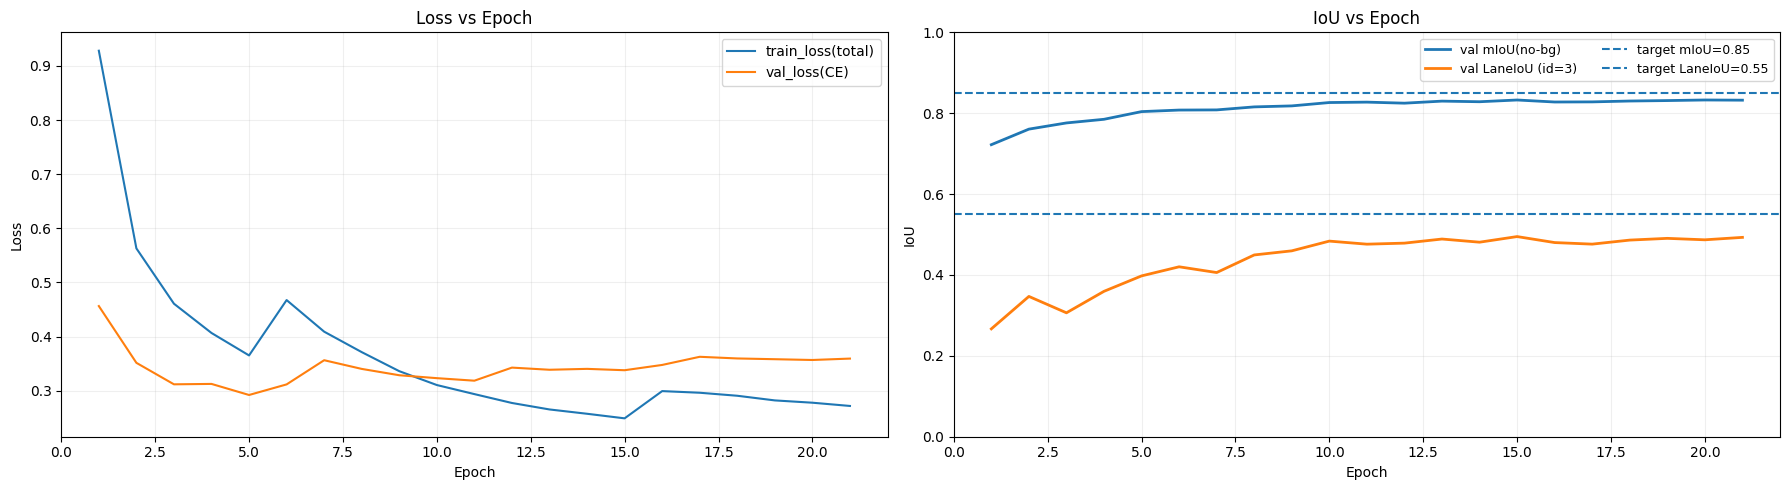

In [66]:
# ============================================================
# ONE CELL (Improved vNext)
# DeepLabV3+ResNet50 + (Lane Dice) + (Lane Emb Reg)
# - LaneDice weight scheduling (low->high) ✅
# - LR slightly down + 1-epoch warmup ✅
# - 기존 출력/가시화/early stopping(score) 유지 ✅
#
# [필수]
# - DEVICE, NUM_CLASSES=7, train_loader, val_loader
# - class_weights(선택), coco(선택), id2train(선택)
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# --------------------
# CONFIG
# --------------------
EPOCHS = 40
PATIENCE = 5

LR = 2e-4                 # ✅ 3e-4 -> 2e-4
WEIGHT_DECAY = 3e-4
LABEL_SMOOTH = 0.0

BEST_PATH = "best_deeplabv3_r50_laneemb_laneDice_vnext.pt"

IGNORE_BG = True
PRINT_BG_IOU = False

TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55
LANE_TRAIN_ID = 3

# ---- Lane Emb (약하게 유지) ----
EMB_DIM = 4
LAMBDA_EMB = 0.02
EMB_MARGIN = 1.0
EMB_MIN_PIXELS = 30

# ---- Lane Dice (스케줄링) ----
# 초반(안정) 낮게 → 후반(차선 강화) 높게
LANE_DICE_W1, LANE_DICE_W2, LANE_DICE_W3 = 0.20, 0.40, 0.60
LANE_DICE_EP1, LANE_DICE_EP2 = 5, 15    # 1~5 / 6~15 / 16~EPOCHS

# (선택) backbone warmup freeze (원하면 1~2)
FREEZE_BACKBONE_WARMUP_EPOCHS = 0

device = torch.device(DEVICE)

# --------------------
# CLASS NAME MAP
# --------------------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i+1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# --------------------
# MODEL
# --------------------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )
        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]
        feat256 = self.feat_extractor(x_out)
        seg = self.seg_head(feat256)
        emb = self.embed_head(feat256)
        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

model = DeepLabV3_WithLaneEmbedding(NUM_CLASSES, emb_dim=EMB_DIM).to(device)

# --------------------
# LOSSES
# --------------------
use_class_weight = True
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
ce_criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

def dice_loss_binary_from_logits(logits, target01, eps=1e-6):
    # logits: (B,H,W), target01: (B,H,W) {0,1}
    prob = torch.sigmoid(logits)
    prob = prob.contiguous().view(prob.size(0), -1)
    tgt  = target01.contiguous().view(target01.size(0), -1).float()
    inter = (prob * tgt).sum(dim=1)
    denom = prob.sum(dim=1) + tgt.sum(dim=1)
    dice = (2 * inter + eps) / (denom + eps)
    return (1 - dice).mean()

def lane_dice_loss(seg_logits, y, lane_id):
    # seg_logits: (B,C,H,W) → lane logit만 뽑아 binary dice
    lane_logit = seg_logits[:, lane_id, :, :]         # (B,H,W)
    lane_tgt = (y == lane_id).float()                 # (B,H,W)
    return dice_loss_binary_from_logits(lane_logit, lane_tgt)

def lane_embedding_loss_simple(emb, y, lane_id: int, margin: float = 1.0, min_pixels: int = 30):
    B, D, H, W = emb.shape
    emb_hw = emb.permute(0, 2, 3, 1).contiguous().view(B, H * W, D)
    y_hw = y.view(B, H * W)
    total = emb.new_tensor(0.0)
    cnt = 0
    for b in range(B):
        lane_mask = (y_hw[b] == lane_id)
        non_mask = ~lane_mask
        if lane_mask.sum() < min_pixels or non_mask.sum() < min_pixels:
            continue
        lane_emb = emb_hw[b][lane_mask]
        non_emb = emb_hw[b][non_mask]
        lane_mean = lane_emb.mean(dim=0, keepdim=True)
        non_mean = non_emb.mean(dim=0, keepdim=True)
        pull = F.mse_loss(lane_emb, lane_mean.expand_as(lane_emb))
        dist = torch.norm(lane_mean - non_mean, p=2)
        push = F.relu(margin - dist)
        total = total + (pull + 0.1 * push)
        cnt += 1
    return total / cnt if cnt > 0 else emb.new_tensor(0.0)

def lane_dice_weight(epoch):
    if epoch <= LANE_DICE_EP1:
        return LANE_DICE_W1
    elif epoch <= LANE_DICE_EP2:
        return LANE_DICE_W2
    else:
        return LANE_DICE_W3

def total_loss_fn(out, y, epoch):
    seg = out["seg"]
    emb = out["emb"]
    loss_ce = ce_criterion(seg, y)
    w_dice = lane_dice_weight(epoch)
    loss_dice = lane_dice_loss(seg, y, LANE_TRAIN_ID)
    loss_emb = lane_embedding_loss_simple(emb, y, LANE_TRAIN_ID, margin=EMB_MARGIN, min_pixels=EMB_MIN_PIXELS)
    loss_total = loss_ce + w_dice * loss_dice + LAMBDA_EMB * loss_emb
    return loss_total, loss_ce.detach(), loss_dice.detach(), loss_emb.detach(), float(w_dice)

# --------------------
# OPT / SCHED (1-epoch warmup + cosine)
# --------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def lr_warmup_cosine(epoch, base_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        return base_lr * (epoch / max(1, warmup_epochs))
    # cosine for remaining
    t = (epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
    return base_lr * 0.5 * (1 + np.cos(np.pi * t))

def set_backbone_trainable(model, trainable: bool):
    for p in model.base.backbone.parameters():
        p.requires_grad = trainable

# --------------------
# METRICS (same)
# --------------------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount((num_classes * target[k] + pred[k]).to(torch.int64),
                          minlength=num_classes**2).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        seg_logits = model(x)["seg"]
        loss = ce_criterion(seg_logits, y)  # val은 CE 기준(일관성)
        total_loss += float(loss.item()); n += 1
        pred = seg_logits.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)
    hist = hist.float()
    diag = torch.diag(hist)
    denom = (hist.sum(1) + hist.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()
    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    return total_loss / max(n, 1), miou, iou

def train_one_epoch(model, loader, epoch):
    model.train()
    tot = tot_ce = tot_dice = tot_emb = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)
        loss, lce, ldice, lemb, w_dice = total_loss_fn(out, y, epoch)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        tot += float(loss.item())
        tot_ce += float(lce.item())
        tot_dice += float(ldice.item())
        tot_emb += float(lemb.item())
        n += 1
    return tot/max(n,1), tot_ce/max(n,1), tot_dice/max(n,1), tot_emb/max(n,1), w_dice

# --------------------
# HISTORY
# --------------------
history = dict(epoch=[], train_loss=[], train_ce=[], train_dice=[], train_emb=[],
               val_loss=[], val_miou=[], val_iou_per_class=[], lane_dice_w=[])

# --------------------
# TRAIN LOOP (score: mIoU + alpha*LaneIoU)
# --------------------
best_score = -1e9
best_epoch = 0
pat = 0

ALPHA_LANE = 0.5  # score = mIoU + ALPHA_LANE*LaneIoU (Lane 중심으로 더 끌기)

print(f"DEVICE={DEVICE} | NUM_CLASSES={NUM_CLASSES} | LR={LR} | WD={WEIGHT_DECAY}")
print(f"LaneDice schedule: {LANE_DICE_W1}->{LANE_DICE_W2}->{LANE_DICE_W3} @ ep {LANE_DICE_EP1}/{LANE_DICE_EP2}")
print(f"Score = mIoU + {ALPHA_LANE}*LaneIoU | Lane id={LANE_TRAIN_ID}")
print(f"Save best to: {BEST_PATH}\n")

for epoch in range(1, EPOCHS + 1):
    # backbone warmup freeze
    if FREEZE_BACKBONE_WARMUP_EPOCHS > 0:
        set_backbone_trainable(model, trainable=(epoch > FREEZE_BACKBONE_WARMUP_EPOCHS))

    # warmup+cosine lr
    cur_lr = lr_warmup_cosine(epoch, LR, warmup_epochs=1, total_epochs=EPOCHS)
    for pg in optimizer.param_groups:
        pg["lr"] = cur_lr

    tr, tr_ce, tr_dice, tr_emb, w_dice = train_one_epoch(model, train_loader, epoch)
    va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)

    lane_iou = float(va_iou_pc[LANE_TRAIN_ID])
    score = va_miou + ALPHA_LANE * lane_iou

    history["epoch"].append(epoch)
    history["train_loss"].append(tr)
    history["train_ce"].append(tr_ce)
    history["train_dice"].append(tr_dice)
    history["train_emb"].append(tr_emb)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["val_iou_per_class"].append(va_iou_pc)
    history["lane_dice_w"].append(w_dice)

    tag = "no-bg" if IGNORE_BG else "with-bg"
    print(f"[{epoch:02d}] lr={cur_lr:.2e} | w_dice={w_dice:.2f} | score={score:.4f} | "
          f"train={tr:.4f} (ce={tr_ce:.4f}, dice={tr_dice:.4f}, emb={tr_emb:.4f}) | "
          f"val_loss={va_loss:.4f} | val_mIoU({tag})={va_miou:.4f} | laneIoU={lane_iou:.4f}")

    start_cid = 0 if PRINT_BG_IOU else 1
    for cid in range(start_cid, NUM_CLASSES):
        name = train2name.get(cid, str(cid))
        v = va_iou_pc[cid]
        txt = "nan" if np.isnan(v) else f"{v:.4f}"
        print(f"  IoU[{cid}] {name}: {txt}")

    improved = score > best_score + 1e-7
    if improved:
        best_score = score
        best_epoch = epoch
        pat = 0
        save_dict = {"model": model.state_dict(), "num_classes": NUM_CLASSES, "emb_dim": EMB_DIM}
        if "id2train" in globals():
            save_dict["id2train"] = id2train
        torch.save(save_dict, BEST_PATH)
        print(f"  ✅ improved! best_score={best_score:.4f} (mIoU={va_miou:.4f}) @ epoch {best_epoch} | patience {pat}/{PATIENCE} | saved\n")
    else:
        pat += 1
        remain = PATIENCE - pat
        print(f"  ❌ no improve | best_score={best_score:.4f} @ epoch {best_epoch} | patience {pat}/{PATIENCE} (remain {max(remain,0)})\n")
        if pat >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Best epoch={best_epoch} | best_score={best_score:.6f}")

# --------------------
# LOAD BEST + FINAL VAL REPORT
# --------------------
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou_best = float(va_iou_pc[LANE_TRAIN_ID])
score_best = va_miou + ALPHA_LANE * lane_iou_best

print("\n[Best Model @ VAL]")
print(f"val_loss={va_loss:.4f} | val_mIoU(no-bg)={va_miou:.4f} | laneIoU={lane_iou_best:.4f} | score={score_best:.4f}")
for cid in range(1, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = va_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# --------------------
# VISUALIZATION: SIDE-BY-SIDE (Loss / IoU)
# --------------------
epochs = np.array(history["epoch"])
train_loss = np.array(history["train_loss"])
val_loss_arr = np.array(history["val_loss"])
val_miou_hist = np.array(history["val_miou"])
val_iou_stack = np.stack(history["val_iou_per_class"], axis=0)
lane_iou_hist = val_iou_stack[:, LANE_TRAIN_ID]

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].plot(epochs, train_loss, label="train_loss(total)")
axes[0].plot(epochs, val_loss_arr, label="val_loss(CE)")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Epoch")
axes[0].grid(True, alpha=0.2)
axes[0].legend()

axes[1].plot(epochs, val_miou_hist, linewidth=2, label="val mIoU(no-bg)")
axes[1].plot(epochs, lane_iou_hist, linewidth=2, label=f"val LaneIoU (id={LANE_TRAIN_ID})")
axes[1].axhline(TARGET_MIOU, linestyle="--", linewidth=1.5, label=f"target mIoU={TARGET_MIOU}")
axes[1].axhline(TARGET_LANE_IOU, linestyle="--", linewidth=1.5, label=f"target LaneIoU={TARGET_LANE_IOU}")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("IoU")
axes[1].set_title("IoU vs Epoch")
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.2)
axes[1].legend(ncol=2, fontsize=9)

plt.tight_layout()
plt.show()

DEVICE=cuda | NUM_CLASSES=7 | LR=0.0002 | WD=0.0003
LaneDice linear ramp: 0.2->0.55 over 20 ep
LaneFocal: lambda=0.08, alpha=0.75, gamma=2.0
Score = mIoU + 0.8*LaneIoU | Lane id=3
Save best to: best_deeplabv3_r50_lane_vnext2.pt



train:   0%|          | 0/40 [00:00<?, ?it/s]

C:\Users\hugctx\AppData\Local\Temp\ipykernel_41028\2798210657.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)


[01] lr=2.00e-04 | w_dice=0.218 | score=0.8916 | train=0.9866 (ce=0.7707, dice=0.9678, focal=0.0585, emb=0.0378) | val_loss=0.4405 | val_mIoU(no-bg)=0.7217 | laneIoU=0.2125
  IoU[1] Undrivable: 0.9085
  IoU[2] Road: 0.7549
  IoU[3] Lane Mark: 0.2125
  IoU[4] Moveable: 0.7132
  IoU[5] My bike: 0.8903
  IoU[6] Rider: 0.8506
  ✅ improved! best_score=0.8916 (mIoU=0.7217) @ epoch 1 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[02] lr=2.00e-04 | w_dice=0.235 | score=1.0172 | train=0.5995 (ce=0.3736, dice=0.9478, focal=0.0382, emb=0.0033) | val_loss=0.3568 | val_mIoU(no-bg)=0.7661 | laneIoU=0.3138
  IoU[1] Undrivable: 0.9273
  IoU[2] Road: 0.8073
  IoU[3] Lane Mark: 0.3138
  IoU[4] Moveable: 0.7450
  IoU[5] My bike: 0.9200
  IoU[6] Rider: 0.8829
  ✅ improved! best_score=1.0172 (mIoU=0.7661) @ epoch 2 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[03] lr=1.99e-04 | w_dice=0.253 | score=1.0481 | train=0.5128 (ce=0.2772, dice=0.9256, focal=0.0233, emb=0.0017) | val_loss=0.3360 | val_mIoU(no-bg)=0.7756 | laneIoU=0.3405
  IoU[1] Undrivable: 0.9206
  IoU[2] Road: 0.8057
  IoU[3] Lane Mark: 0.3405
  IoU[4] Moveable: 0.7611
  IoU[5] My bike: 0.9302
  IoU[6] Rider: 0.8955
  ✅ improved! best_score=1.0481 (mIoU=0.7756) @ epoch 3 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[04] lr=1.98e-04 | w_dice=0.270 | score=1.0508 | train=0.4703 (ce=0.2290, dice=0.8886, focal=0.0173, emb=0.0015) | val_loss=0.3282 | val_mIoU(no-bg)=0.7816 | laneIoU=0.3364
  IoU[1] Undrivable: 0.9320
  IoU[2] Road: 0.8218
  IoU[3] Lane Mark: 0.3364
  IoU[4] Moveable: 0.7553
  IoU[5] My bike: 0.9360
  IoU[6] Rider: 0.9083
  ✅ improved! best_score=1.0508 (mIoU=0.7816) @ epoch 4 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[05] lr=1.96e-04 | w_dice=0.288 | score=1.0830 | train=0.4385 (ce=0.2003, dice=0.8249, focal=0.0118, emb=0.0011) | val_loss=0.3257 | val_mIoU(no-bg)=0.7930 | laneIoU=0.3625
  IoU[1] Undrivable: 0.9354
  IoU[2] Road: 0.8329
  IoU[3] Lane Mark: 0.3625
  IoU[4] Moveable: 0.7692
  IoU[5] My bike: 0.9402
  IoU[6] Rider: 0.9179
  ✅ improved! best_score=1.0830 (mIoU=0.7930) @ epoch 5 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[06] lr=1.94e-04 | w_dice=0.305 | score=1.1447 | train=0.4104 (ce=0.1873, dice=0.7296, focal=0.0078, emb=0.0006) | val_loss=0.3216 | val_mIoU(no-bg)=0.8083 | laneIoU=0.4205
  IoU[1] Undrivable: 0.9389
  IoU[2] Road: 0.8439
  IoU[3] Lane Mark: 0.4205
  IoU[4] Moveable: 0.7886
  IoU[5] My bike: 0.9437
  IoU[6] Rider: 0.9142
  ✅ improved! best_score=1.1447 (mIoU=0.8083) @ epoch 6 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[07] lr=1.91e-04 | w_dice=0.323 | score=1.1656 | train=0.3737 (ce=0.1756, dice=0.6132, focal=0.0047, emb=0.0007) | val_loss=0.3222 | val_mIoU(no-bg)=0.8121 | laneIoU=0.4418
  IoU[1] Undrivable: 0.9379
  IoU[2] Road: 0.8466
  IoU[3] Lane Mark: 0.4418
  IoU[4] Moveable: 0.7875
  IoU[5] My bike: 0.9443
  IoU[6] Rider: 0.9147
  ✅ improved! best_score=1.1656 (mIoU=0.8121) @ epoch 7 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[08] lr=1.88e-04 | w_dice=0.340 | score=1.1616 | train=0.3478 (ce=0.1711, dice=0.5189, focal=0.0039, emb=0.0006) | val_loss=0.3372 | val_mIoU(no-bg)=0.8112 | laneIoU=0.4381
  IoU[1] Undrivable: 0.9351
  IoU[2] Road: 0.8501
  IoU[3] Lane Mark: 0.4381
  IoU[4] Moveable: 0.7779
  IoU[5] My bike: 0.9462
  IoU[6] Rider: 0.9196
  ❌ no improve | best_score=1.1656 @ epoch 7 | patience 1/7 (remain 6)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[09] lr=1.84e-04 | w_dice=0.358 | score=1.1832 | train=0.3292 (ce=0.1655, dice=0.4569, focal=0.0039, emb=0.0006) | val_loss=0.3160 | val_mIoU(no-bg)=0.8155 | laneIoU=0.4596
  IoU[1] Undrivable: 0.9375
  IoU[2] Road: 0.8474
  IoU[3] Lane Mark: 0.4596
  IoU[4] Moveable: 0.7878
  IoU[5] My bike: 0.9434
  IoU[6] Rider: 0.9175
  ✅ improved! best_score=1.1832 (mIoU=0.8155) @ epoch 9 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[10] lr=1.80e-04 | w_dice=0.375 | score=1.2116 | train=0.3135 (ce=0.1579, dice=0.4141, focal=0.0039, emb=0.0004) | val_loss=0.3289 | val_mIoU(no-bg)=0.8221 | laneIoU=0.4868
  IoU[1] Undrivable: 0.9407
  IoU[2] Road: 0.8543
  IoU[3] Lane Mark: 0.4868
  IoU[4] Moveable: 0.7919
  IoU[5] My bike: 0.9409
  IoU[6] Rider: 0.9183
  ✅ improved! best_score=1.2116 (mIoU=0.8221) @ epoch 10 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[11] lr=1.76e-04 | w_dice=0.393 | score=1.1865 | train=0.2988 (ce=0.1493, dice=0.3800, focal=0.0036, emb=0.0003) | val_loss=0.3368 | val_mIoU(no-bg)=0.8213 | laneIoU=0.4565
  IoU[1] Undrivable: 0.9436
  IoU[2] Road: 0.8618
  IoU[3] Lane Mark: 0.4565
  IoU[4] Moveable: 0.7886
  IoU[5] My bike: 0.9463
  IoU[6] Rider: 0.9308
  ❌ no improve | best_score=1.2116 @ epoch 10 | patience 1/7 (remain 6)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[12] lr=1.71e-04 | w_dice=0.410 | score=1.1960 | train=0.2897 (ce=0.1444, dice=0.3536, focal=0.0037, emb=0.0004) | val_loss=0.3330 | val_mIoU(no-bg)=0.8218 | laneIoU=0.4677
  IoU[1] Undrivable: 0.9402
  IoU[2] Road: 0.8626
  IoU[3] Lane Mark: 0.4677
  IoU[4] Moveable: 0.7807
  IoU[5] My bike: 0.9478
  IoU[6] Rider: 0.9320
  ❌ no improve | best_score=1.2116 @ epoch 10 | patience 2/7 (remain 5)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[13] lr=1.65e-04 | w_dice=0.428 | score=1.1996 | train=0.2815 (ce=0.1386, dice=0.3337, focal=0.0037, emb=0.0003) | val_loss=0.3205 | val_mIoU(no-bg)=0.8245 | laneIoU=0.4689
  IoU[1] Undrivable: 0.9402
  IoU[2] Road: 0.8568
  IoU[3] Lane Mark: 0.4689
  IoU[4] Moveable: 0.7969
  IoU[5] My bike: 0.9509
  IoU[6] Rider: 0.9334
  ❌ no improve | best_score=1.2116 @ epoch 10 | patience 3/7 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[14] lr=1.60e-04 | w_dice=0.445 | score=1.2133 | train=0.2764 (ce=0.1331, dice=0.3213, focal=0.0036, emb=0.0002) | val_loss=0.3412 | val_mIoU(no-bg)=0.8239 | laneIoU=0.4868
  IoU[1] Undrivable: 0.9399
  IoU[2] Road: 0.8603
  IoU[3] Lane Mark: 0.4868
  IoU[4] Moveable: 0.7819
  IoU[5] My bike: 0.9495
  IoU[6] Rider: 0.9252
  ✅ improved! best_score=1.2133 (mIoU=0.8239) @ epoch 14 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[15] lr=1.54e-04 | w_dice=0.463 | score=1.2182 | train=0.2757 (ce=0.1300, dice=0.3143, focal=0.0039, emb=0.0003) | val_loss=0.3402 | val_mIoU(no-bg)=0.8273 | laneIoU=0.4886
  IoU[1] Undrivable: 0.9439
  IoU[2] Road: 0.8669
  IoU[3] Lane Mark: 0.4886
  IoU[4] Moveable: 0.7831
  IoU[5] My bike: 0.9501
  IoU[6] Rider: 0.9314
  ✅ improved! best_score=1.2182 (mIoU=0.8273) @ epoch 15 | patience 0/7 | saved



train:   0%|          | 0/40 [00:00<?, ?it/s]

[16] lr=1.48e-04 | w_dice=0.480 | score=1.2126 | train=0.2701 (ce=0.1248, dice=0.3021, focal=0.0037, emb=0.0002) | val_loss=0.3575 | val_mIoU(no-bg)=0.8279 | laneIoU=0.4809
  IoU[1] Undrivable: 0.9414
  IoU[2] Road: 0.8640
  IoU[3] Lane Mark: 0.4809
  IoU[4] Moveable: 0.7970
  IoU[5] My bike: 0.9514
  IoU[6] Rider: 0.9325
  ❌ no improve | best_score=1.2182 @ epoch 15 | patience 1/7 (remain 6)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[17] lr=1.42e-04 | w_dice=0.498 | score=1.1971 | train=0.2710 (ce=0.1234, dice=0.2960, focal=0.0040, emb=0.0002) | val_loss=0.3569 | val_mIoU(no-bg)=0.8234 | laneIoU=0.4672
  IoU[1] Undrivable: 0.9398
  IoU[2] Road: 0.8585
  IoU[3] Lane Mark: 0.4672
  IoU[4] Moveable: 0.7936
  IoU[5] My bike: 0.9514
  IoU[6] Rider: 0.9297
  ❌ no improve | best_score=1.2182 @ epoch 15 | patience 2/7 (remain 5)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[18] lr=1.35e-04 | w_dice=0.515 | score=1.2096 | train=0.2679 (ce=0.1196, dice=0.2873, focal=0.0039, emb=0.0002) | val_loss=0.3620 | val_mIoU(no-bg)=0.8271 | laneIoU=0.4782
  IoU[1] Undrivable: 0.9427
  IoU[2] Road: 0.8649
  IoU[3] Lane Mark: 0.4782
  IoU[4] Moveable: 0.7932
  IoU[5] My bike: 0.9522
  IoU[6] Rider: 0.9312
  ❌ no improve | best_score=1.2182 @ epoch 15 | patience 3/7 (remain 4)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[19] lr=1.28e-04 | w_dice=0.532 | score=1.2029 | train=0.2684 (ce=0.1174, dice=0.2830, focal=0.0040, emb=0.0002) | val_loss=0.3667 | val_mIoU(no-bg)=0.8253 | laneIoU=0.4721
  IoU[1] Undrivable: 0.9416
  IoU[2] Road: 0.8636
  IoU[3] Lane Mark: 0.4721
  IoU[4] Moveable: 0.7856
  IoU[5] My bike: 0.9518
  IoU[6] Rider: 0.9367
  ❌ no improve | best_score=1.2182 @ epoch 15 | patience 4/7 (remain 3)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[20] lr=1.21e-04 | w_dice=0.550 | score=1.2102 | train=0.2654 (ce=0.1138, dice=0.2750, focal=0.0039, emb=0.0002) | val_loss=0.3496 | val_mIoU(no-bg)=0.8270 | laneIoU=0.4789
  IoU[1] Undrivable: 0.9437
  IoU[2] Road: 0.8658
  IoU[3] Lane Mark: 0.4789
  IoU[4] Moveable: 0.7905
  IoU[5] My bike: 0.9526
  IoU[6] Rider: 0.9307
  ❌ no improve | best_score=1.2182 @ epoch 15 | patience 5/7 (remain 2)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[21] lr=1.14e-04 | w_dice=0.550 | score=1.1997 | train=0.2618 (ce=0.1122, dice=0.2714, focal=0.0040, emb=0.0002) | val_loss=0.3545 | val_mIoU(no-bg)=0.8248 | laneIoU=0.4686
  IoU[1] Undrivable: 0.9426
  IoU[2] Road: 0.8608
  IoU[3] Lane Mark: 0.4686
  IoU[4] Moveable: 0.7898
  IoU[5] My bike: 0.9519
  IoU[6] Rider: 0.9351
  ❌ no improve | best_score=1.2182 @ epoch 15 | patience 6/7 (remain 1)



train:   0%|          | 0/40 [00:00<?, ?it/s]

[22] lr=1.07e-04 | w_dice=0.550 | score=1.2010 | train=0.2567 (ce=0.1103, dice=0.2656, focal=0.0040, emb=0.0002) | val_loss=0.3645 | val_mIoU(no-bg)=0.8245 | laneIoU=0.4706
  IoU[1] Undrivable: 0.9412
  IoU[2] Road: 0.8607
  IoU[3] Lane Mark: 0.4706
  IoU[4] Moveable: 0.7904
  IoU[5] My bike: 0.9542
  IoU[6] Rider: 0.9301
  ❌ no improve | best_score=1.2182 @ epoch 15 | patience 7/7 (remain 0)

Early stopping triggered.
Best epoch=15 | best_score=1.218207

[Best Model @ VAL]
val_loss=0.3402 | val_mIoU(no-bg)=0.8273 | laneIoU=0.4886 | score=1.2182
  IoU[1] Undrivable: 0.9439
  IoU[2] Road: 0.8669
  IoU[3] Lane Mark: 0.4886
  IoU[4] Moveable: 0.7831
  IoU[5] My bike: 0.9501
  IoU[6] Rider: 0.9314


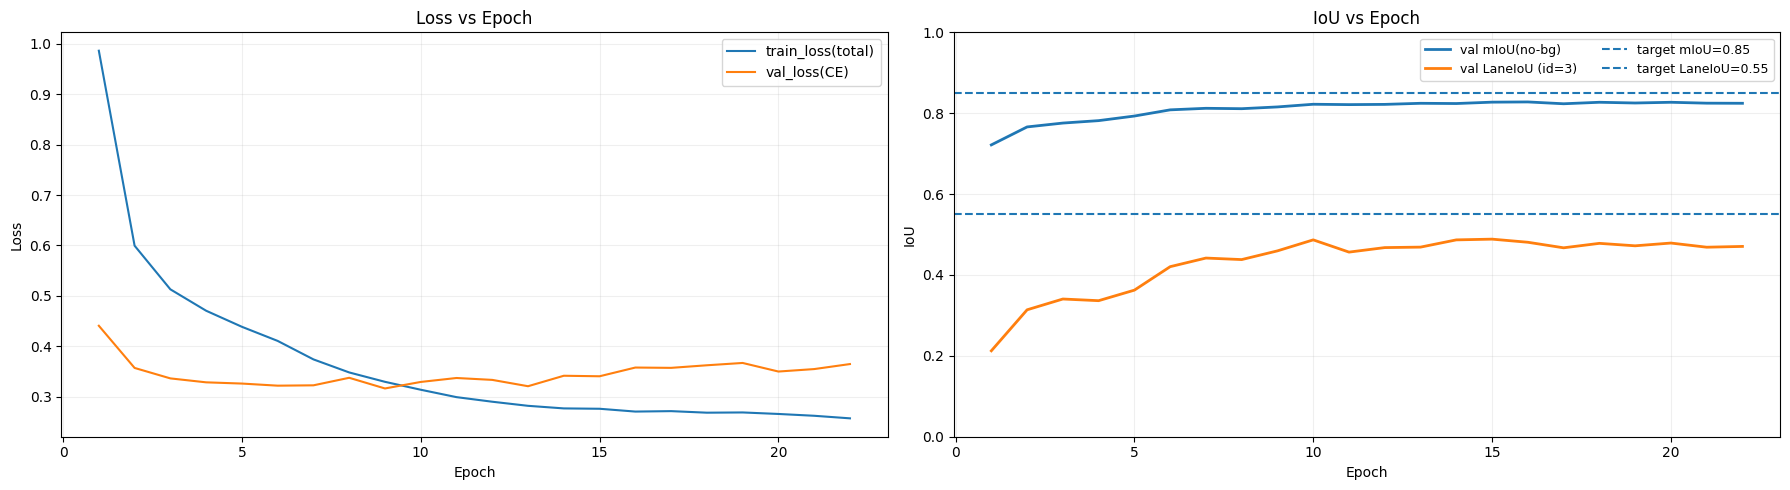

In [68]:
# ============================================================
# ONE CELL (vNext-2)
# DeepLabV3+ResNet50 + LaneDice(Linear Ramp) + LaneFocalBCE(weak) + LaneEmbReg(weak)
#
# 변화점(핵심)
# 1) LaneDice weight: 계단(0.2->0.4->0.6) 제거, 선형 램프 ✅
# 2) Lane Focal BCE를 아주 약하게 추가 ✅
# 3) score = mIoU + 0.8*LaneIoU (Lane 목표 우선) ✅
#
# [필수]
# - DEVICE, NUM_CLASSES=7, train_loader, val_loader
# - class_weights(선택), coco(선택), id2train(선택)
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# --------------------
# CONFIG
# --------------------
EPOCHS = 45
PATIENCE = 7

LR = 2e-4
WEIGHT_DECAY = 3e-4
LABEL_SMOOTH = 0.0

BEST_PATH = "best_deeplabv3_r50_lane_vnext2.pt"

IGNORE_BG = True
PRINT_BG_IOU = False

TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55
LANE_TRAIN_ID = 3

# ---- Lane Emb (약하게 유지) ----
EMB_DIM = 4
LAMBDA_EMB = 0.02
EMB_MARGIN = 1.0
EMB_MIN_PIXELS = 30

# ---- Lane Dice linear ramp ----
LANE_DICE_W_START = 0.20
LANE_DICE_W_END   = 0.55     # ✅ 0.60은 이번 로그에서 흔들림 유발. 0.55로 완만하게
LANE_DICE_RAMP_EPOCHS = 20   # 1~20ep 동안 천천히 증가 후 고정

# ---- Lane Focal BCE (아주 약하게) ----
LAMBDA_LANE_FOCAL = 0.08     # ✅ 작게 시작(0.05~0.12 범위)
FOCAL_ALPHA = 0.75
FOCAL_GAMMA = 2.0

# ---- score (early stopping 기준) ----
ALPHA_LANE = 0.8             # ✅ Lane 목표 우선

# (선택) backbone warmup freeze
FREEZE_BACKBONE_WARMUP_EPOCHS = 0

device = torch.device(DEVICE)

# --------------------
# CLASS NAME MAP
# --------------------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i+1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# --------------------
# MODEL
# --------------------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )
        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]
        feat256 = self.feat_extractor(x_out)
        seg = self.seg_head(feat256)
        emb = self.embed_head(feat256)
        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

model = DeepLabV3_WithLaneEmbedding(NUM_CLASSES, emb_dim=EMB_DIM).to(device)

# --------------------
# LOSSES
# --------------------
use_class_weight = True
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
ce_criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

def lane_dice_weight(epoch: int):
    # ✅ 선형 램프: 1~LANE_DICE_RAMP_EPOCHS 동안 0.20 -> 0.55로 증가, 이후 고정
    t = min(epoch, LANE_DICE_RAMP_EPOCHS) / max(1, LANE_DICE_RAMP_EPOCHS)
    return LANE_DICE_W_START + t * (LANE_DICE_W_END - LANE_DICE_W_START)

def dice_loss_binary_from_logits(logits, target01, eps=1e-6):
    prob = torch.sigmoid(logits)
    prob = prob.contiguous().view(prob.size(0), -1)
    tgt  = target01.contiguous().view(target01.size(0), -1).float()
    inter = (prob * tgt).sum(dim=1)
    denom = prob.sum(dim=1) + tgt.sum(dim=1)
    dice = (2 * inter + eps) / (denom + eps)
    return (1 - dice).mean()

def lane_dice_loss(seg_logits, y, lane_id):
    lane_logit = seg_logits[:, lane_id, :, :]         # (B,H,W)
    lane_tgt = (y == lane_id).float()                 # (B,H,W)
    return dice_loss_binary_from_logits(lane_logit, lane_tgt)

def focal_bce_with_logits(logits, targets01, alpha=0.75, gamma=2.0, eps=1e-6):
    # logits: (B,H,W), targets01: (B,H,W) float {0,1}
    bce = F.binary_cross_entropy_with_logits(logits, targets01, reduction="none")
    p = torch.sigmoid(logits)
    pt = p * targets01 + (1 - p) * (1 - targets01)
    w = alpha * targets01 + (1 - alpha) * (1 - targets01)
    focal = w * (1 - pt).clamp(min=0.0, max=1.0).pow(gamma) * bce
    return focal.mean()

def lane_focal_loss(seg_logits, y, lane_id):
    lane_logit = seg_logits[:, lane_id, :, :]
    lane_tgt = (y == lane_id).float()
    return focal_bce_with_logits(lane_logit, lane_tgt, alpha=FOCAL_ALPHA, gamma=FOCAL_GAMMA)

def lane_embedding_loss_simple(emb, y, lane_id: int, margin: float = 1.0, min_pixels: int = 30):
    B, D, H, W = emb.shape
    emb_hw = emb.permute(0, 2, 3, 1).contiguous().view(B, H * W, D)
    y_hw = y.view(B, H * W)
    total = emb.new_tensor(0.0)
    cnt = 0
    for b in range(B):
        lane_mask = (y_hw[b] == lane_id)
        non_mask = ~lane_mask
        if lane_mask.sum() < min_pixels or non_mask.sum() < min_pixels:
            continue
        lane_emb = emb_hw[b][lane_mask]
        non_emb = emb_hw[b][non_mask]
        lane_mean = lane_emb.mean(dim=0, keepdim=True)
        non_mean = non_emb.mean(dim=0, keepdim=True)
        pull = F.mse_loss(lane_emb, lane_mean.expand_as(lane_emb))
        dist = torch.norm(lane_mean - non_mean, p=2)
        push = F.relu(margin - dist)
        total = total + (pull + 0.1 * push)
        cnt += 1
    return total / cnt if cnt > 0 else emb.new_tensor(0.0)

def total_loss_fn(out, y, epoch):
    seg = out["seg"]
    emb = out["emb"]
    loss_ce = ce_criterion(seg, y)
    w_dice = lane_dice_weight(epoch)
    loss_dice = lane_dice_loss(seg, y, LANE_TRAIN_ID)
    loss_focal = lane_focal_loss(seg, y, LANE_TRAIN_ID)
    loss_emb = lane_embedding_loss_simple(emb, y, LANE_TRAIN_ID, margin=EMB_MARGIN, min_pixels=EMB_MIN_PIXELS)
    loss_total = loss_ce + w_dice * loss_dice + LAMBDA_LANE_FOCAL * loss_focal + LAMBDA_EMB * loss_emb
    return loss_total, loss_ce.detach(), loss_dice.detach(), loss_focal.detach(), loss_emb.detach(), float(w_dice)

# --------------------
# OPT / LR SCHED (warmup 1ep + cosine)
# --------------------
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

def lr_warmup_cosine(epoch, base_lr, warmup_epochs, total_epochs):
    if epoch <= warmup_epochs:
        return base_lr * (epoch / max(1, warmup_epochs))
    t = (epoch - warmup_epochs) / max(1, (total_epochs - warmup_epochs))
    return base_lr * 0.5 * (1 + np.cos(np.pi * t))

def set_backbone_trainable(model, trainable: bool):
    for p in model.base.backbone.parameters():
        p.requires_grad = trainable

# --------------------
# METRICS
# --------------------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount((num_classes * target[k] + pred[k]).to(torch.int64),
                          minlength=num_classes**2).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        seg_logits = model(x)["seg"]
        loss = ce_criterion(seg_logits, y)  # val은 CE 기준으로 일관
        total_loss += float(loss.item()); n += 1
        pred = seg_logits.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)
    hist = hist.float()
    diag = torch.diag(hist)
    denom = (hist.sum(1) + hist.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()
    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    return total_loss / max(n, 1), miou, iou

def train_one_epoch(model, loader, epoch):
    model.train()
    tot = tot_ce = tot_dice = tot_focal = tot_emb = 0.0
    n = 0
    for x, y in tqdm(loader, desc="train", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)
        loss, lce, ldice, lfocal, lemb, w_dice = total_loss_fn(out, y, epoch)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        tot += float(loss.item())
        tot_ce += float(lce.item())
        tot_dice += float(ldice.item())
        tot_focal += float(lfocal.item())
        tot_emb += float(lemb.item())
        n += 1
    return tot/max(n,1), tot_ce/max(n,1), tot_dice/max(n,1), tot_focal/max(n,1), tot_emb/max(n,1), w_dice

# --------------------
# HISTORY
# --------------------
history = dict(epoch=[], train_loss=[], train_ce=[], train_dice=[], train_focal=[], train_emb=[],
               val_loss=[], val_miou=[], val_iou_per_class=[], lane_dice_w=[])

# --------------------
# TRAIN LOOP (EarlyStopping: score)
# --------------------
best_score = -1e9
best_epoch = 0
pat = 0

print(f"DEVICE={DEVICE} | NUM_CLASSES={NUM_CLASSES} | LR={LR} | WD={WEIGHT_DECAY}")
print(f"LaneDice linear ramp: {LANE_DICE_W_START}->{LANE_DICE_W_END} over {LANE_DICE_RAMP_EPOCHS} ep")
print(f"LaneFocal: lambda={LAMBDA_LANE_FOCAL}, alpha={FOCAL_ALPHA}, gamma={FOCAL_GAMMA}")
print(f"Score = mIoU + {ALPHA_LANE}*LaneIoU | Lane id={LANE_TRAIN_ID}")
print(f"Save best to: {BEST_PATH}\n")

for epoch in range(1, EPOCHS + 1):
    if FREEZE_BACKBONE_WARMUP_EPOCHS > 0:
        set_backbone_trainable(model, trainable=(epoch > FREEZE_BACKBONE_WARMUP_EPOCHS))

    cur_lr = lr_warmup_cosine(epoch, LR, warmup_epochs=1, total_epochs=EPOCHS)
    for pg in optimizer.param_groups:
        pg["lr"] = cur_lr

    tr, tr_ce, tr_dice, tr_focal, tr_emb, w_dice = train_one_epoch(model, train_loader, epoch)
    va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)

    lane_iou = float(va_iou_pc[LANE_TRAIN_ID])
    score = va_miou + ALPHA_LANE * lane_iou

    history["epoch"].append(epoch)
    history["train_loss"].append(tr)
    history["train_ce"].append(tr_ce)
    history["train_dice"].append(tr_dice)
    history["train_focal"].append(tr_focal)
    history["train_emb"].append(tr_emb)
    history["val_loss"].append(va_loss)
    history["val_miou"].append(va_miou)
    history["val_iou_per_class"].append(va_iou_pc)
    history["lane_dice_w"].append(w_dice)

    tag = "no-bg" if IGNORE_BG else "with-bg"
    print(f"[{epoch:02d}] lr={cur_lr:.2e} | w_dice={w_dice:.3f} | score={score:.4f} | "
          f"train={tr:.4f} (ce={tr_ce:.4f}, dice={tr_dice:.4f}, focal={tr_focal:.4f}, emb={tr_emb:.4f}) | "
          f"val_loss={va_loss:.4f} | val_mIoU({tag})={va_miou:.4f} | laneIoU={lane_iou:.4f}")

    start_cid = 0 if PRINT_BG_IOU else 1
    for cid in range(start_cid, NUM_CLASSES):
        name = train2name.get(cid, str(cid))
        v = va_iou_pc[cid]
        txt = "nan" if np.isnan(v) else f"{v:.4f}"
        print(f"  IoU[{cid}] {name}: {txt}")

    improved = score > best_score + 1e-7
    if improved:
        best_score = score
        best_epoch = epoch
        pat = 0
        save_dict = {"model": model.state_dict(), "num_classes": NUM_CLASSES, "emb_dim": EMB_DIM}
        if "id2train" in globals():
            save_dict["id2train"] = id2train
        torch.save(save_dict, BEST_PATH)
        print(f"  ✅ improved! best_score={best_score:.4f} (mIoU={va_miou:.4f}) @ epoch {best_epoch} | patience {pat}/{PATIENCE} | saved\n")
    else:
        pat += 1
        remain = PATIENCE - pat
        print(f"  ❌ no improve | best_score={best_score:.4f} @ epoch {best_epoch} | patience {pat}/{PATIENCE} (remain {max(remain,0)})\n")
        if pat >= PATIENCE:
            print("Early stopping triggered.")
            break

print(f"Best epoch={best_epoch} | best_score={best_score:.6f}")

# --------------------
# LOAD BEST + FINAL VAL REPORT
# --------------------
ckpt = torch.load(BEST_PATH, map_location=device)
model.load_state_dict(ckpt["model"])
va_loss, va_miou, va_iou_pc = evaluate(model, val_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou_best = float(va_iou_pc[LANE_TRAIN_ID])
score_best = va_miou + ALPHA_LANE * lane_iou_best

print("\n[Best Model @ VAL]")
print(f"val_loss={va_loss:.4f} | val_mIoU(no-bg)={va_miou:.4f} | laneIoU={lane_iou_best:.4f} | score={score_best:.4f}")
for cid in range(1, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = va_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# --------------------
# VISUALIZATION
# --------------------
epochs = np.array(history["epoch"])
train_loss = np.array(history["train_loss"])
val_loss_arr = np.array(history["val_loss"])
val_miou_hist = np.array(history["val_miou"])
val_iou_stack = np.stack(history["val_iou_per_class"], axis=0)
lane_iou_hist = val_iou_stack[:, LANE_TRAIN_ID]
w_dice_hist = np.array(history["lane_dice_w"])

fig, axes = plt.subplots(1, 2, figsize=(18, 5))

axes[0].plot(epochs, train_loss, label="train_loss(total)")
axes[0].plot(epochs, val_loss_arr, label="val_loss(CE)")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Loss")
axes[0].set_title("Loss vs Epoch")
axes[0].grid(True, alpha=0.2)
axes[0].legend()

axes[1].plot(epochs, val_miou_hist, linewidth=2, label="val mIoU(no-bg)")
axes[1].plot(epochs, lane_iou_hist, linewidth=2, label=f"val LaneIoU (id={LANE_TRAIN_ID})")
axes[1].axhline(TARGET_MIOU, linestyle="--", linewidth=1.5, label=f"target mIoU={TARGET_MIOU}")
axes[1].axhline(TARGET_LANE_IOU, linestyle="--", linewidth=1.5, label=f"target LaneIoU={TARGET_LANE_IOU}")
axes[1].set_xlabel("Epoch"); axes[1].set_ylabel("IoU")
axes[1].set_title("IoU vs Epoch")
axes[1].set_ylim(0.0, 1.0)
axes[1].grid(True, alpha=0.2)
axes[1].legend(ncol=2, fontsize=9)

plt.tight_layout()
plt.show()


test:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\hugctx\AppData\Local\Temp\ipykernel_41028\2798210657.py:64: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  mask_pil = Image.fromarray(mask.astype(np.uint8), mode="L").resize(self.size, Image.NEAREST)


[TEST] loss=0.4802 | mIoU(no-bg)=0.7974 | laneIoU(train_id=3)=0.4667
Targets: mIoU>=0.85, LaneIoU>=0.55
  IoU[1] Undrivable: 0.9443
  IoU[2] Road: 0.8583
  IoU[3] Lane Mark: 0.4667
  IoU[4] Moveable: 0.6437
  IoU[5] My bike: 0.9410
  IoU[6] Rider: 0.9302


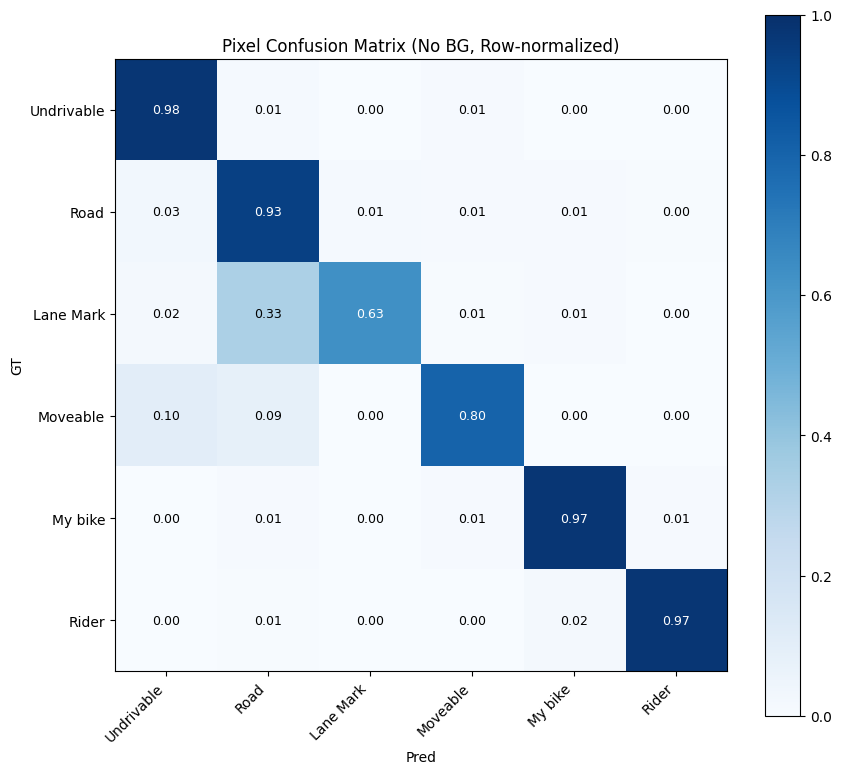

In [84]:
# ============================================================
# DeepLabV3+ResNet50 + Lane Embedding Head (Aux) + LaneDice 학습모델 평가
# - loads BEST_PATH
# - computes: test_loss(CE), test_mIoU(no-bg), laneIoU, per-class IoU
# - confusion matrix: no-bg(6x6), row-normalized + class names
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.models.segmentation import deeplabv3_resnet50
from tqdm.auto import tqdm

# ---------- config ----------
#BEST_PATH = "best_deeplabv3_r50_laneemb_laneDice_vnext.pt"
BEST_PATH = "best_deeplabv3_r50_lane_vnext2.pt"  # ✅ 학습 때 저장한 best로 바꾸세요

IGNORE_BG = True
PRINT_BG_IOU = False

LANE_TRAIN_ID = 3
TARGET_MIOU = 0.85
TARGET_LANE_IOU = 0.55

LABEL_SMOOTH = 0.0
use_class_weight = True

device = torch.device(DEVICE)

# ---------- class name map (train_id -> name) ----------
train2name = {0: "background"}
try:
    id2name = {c["id"]: c["name"] for c in coco.cats.values()}
    cat_ids = sorted(coco.getCatIds())
    train2name.update({i + 1: id2name[cid] for i, cid in enumerate(cat_ids)})
except Exception:
    pass

# ---------- model: DeepLabV3 + Lane Embedding ----------
class DeepLabV3_WithLaneEmbedding(nn.Module):
    """
    out["seg"]: (B, num_classes, H, W)
    out["emb"]: (B, emb_dim, H, W)  # 테스트에서는 emb는 사용 안 해도 됨
    """
    def __init__(self, num_classes: int, emb_dim: int = 4, backbone_pretrained=True, dropout_p=0.1):
        super().__init__()
        self.base = deeplabv3_resnet50(
            weights=None,
            weights_backbone="DEFAULT" if backbone_pretrained else None
        )

        cls_children = list(self.base.classifier.children())
        self.feat_extractor = nn.Sequential(*cls_children[:-1])  # -> (B,256,h,w)

        last = cls_children[-1]
        in_ch = getattr(last, "in_channels", 256)
        self.seg_head = nn.Conv2d(in_ch, num_classes, kernel_size=1)
        self.base.classifier = nn.Sequential(*cls_children[:-1], self.seg_head)

        self.embed_head = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout_p),
            nn.Conv2d(256, emb_dim, 1),
        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        feats = self.base.backbone(x)
        x_out = feats["out"]
        feat256 = self.feat_extractor(x_out)
        seg = self.seg_head(feat256)
        emb = self.embed_head(feat256)

        seg = F.interpolate(seg, size=input_shape, mode="bilinear", align_corners=False)
        emb = F.interpolate(emb, size=input_shape, mode="bilinear", align_corners=False)
        return {"seg": seg, "emb": emb}

# ---------- loss (for reporting) ----------
w = class_weights.to(device) if ("class_weights" in globals() and use_class_weight) else None
criterion = nn.CrossEntropyLoss(weight=w, label_smoothing=LABEL_SMOOTH)

# ---------- load best ----------
ckpt = torch.load(BEST_PATH, map_location=device)

# emb_dim 추론(ckpt에 없으면 기본 4로)
EMB_DIM = int(ckpt.get("emb_dim", 4)) if isinstance(ckpt, dict) else 4

model = DeepLabV3_WithLaneEmbedding(
    num_classes=NUM_CLASSES,
    emb_dim=EMB_DIM,
    backbone_pretrained=True,
    dropout_p=0.1
).to(device)

# 저장 포맷 방어: {"model": state_dict} or state_dict 직접 저장
state = ckpt["model"] if isinstance(ckpt, dict) and "model" in ckpt else ckpt
model.load_state_dict(state, strict=True)
model.eval()

# ---------- metrics ----------
@torch.no_grad()
def fast_hist(pred, target, num_classes):
    k = (target >= 0) & (target < num_classes)
    return torch.bincount(
        (num_classes * target[k] + pred[k]).to(torch.int64),
        minlength=num_classes**2
    ).reshape(num_classes, num_classes)

@torch.no_grad()
def evaluate_test(model, loader, num_classes, ignore_bg=True):
    model.eval()
    hist = torch.zeros((num_classes, num_classes), dtype=torch.int64)
    total_loss = 0.0
    n = 0

    for x, y in tqdm(loader, desc="test", leave=False):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        out = model(x)["seg"]  # ✅ 새 모델은 "seg"
        loss = criterion(out, y)
        total_loss += float(loss.item())
        n += 1

        pred = out.argmax(dim=1)
        for b in range(pred.size(0)):
            hist += fast_hist(pred[b].cpu(), y[b].cpu(), num_classes)

    hist_f = hist.float()
    diag = torch.diag(hist_f)
    denom = (hist_f.sum(1) + hist_f.sum(0) - diag).clamp(min=1.0)
    iou = (diag / denom).cpu().numpy()

    miou = float(np.nanmean(iou[1:])) if ignore_bg else float(np.nanmean(iou))
    avg_loss = total_loss / max(n, 1)

    return avg_loss, miou, iou, hist.cpu().numpy()

# ---------- run test ----------
test_loss, test_miou, test_iou_pc, test_hist = evaluate_test(model, test_loader, NUM_CLASSES, ignore_bg=IGNORE_BG)
lane_iou = float(test_iou_pc[LANE_TRAIN_ID])

tag = "no-bg" if IGNORE_BG else "with-bg"
print(f"[TEST] loss={test_loss:.4f} | mIoU({tag})={test_miou:.4f} | laneIoU(train_id={LANE_TRAIN_ID})={lane_iou:.4f}")
print(f"Targets: mIoU>={TARGET_MIOU}, LaneIoU>={TARGET_LANE_IOU}")

start_cid = 0 if PRINT_BG_IOU else 1
for cid in range(start_cid, NUM_CLASSES):
    name = train2name.get(cid, str(cid))
    v = test_iou_pc[cid]
    txt = "nan" if np.isnan(v) else f"{v:.4f}"
    print(f"  IoU[{cid}] {name}: {txt}")

# ============================================================
# Confusion Matrix (No BG: (NUM_CLASSES-1)x(NUM_CLASSES-1))
# Row-normalized (GT 기준) + 클래스 이름 + 숫자 표시
# ============================================================

cm_no_bg = test_hist[1:, 1:].astype(np.float32)

row_sum = cm_no_bg.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm_no_bg, row_sum, where=row_sum != 0)

class_names = [train2name.get(i, str(i)) for i in range(1, NUM_CLASSES)]

plt.figure(figsize=(9, 8))
plt.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)

plt.title("Pixel Confusion Matrix (No BG, Row-normalized)")
plt.xlabel("Pred")
plt.ylabel("GT")

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        plt.text(
            j, i, f"{cm_norm[i, j]:.2f}",
            ha="center", va="center",
            color="white" if cm_norm[i, j] > 0.5 else "black",
            fontsize=9
        )

plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(range(len(class_names)), class_names)

plt.colorbar()
plt.tight_layout()
plt.show()
